#Project Name : PhonePe Project

#Problem Statement

With the rapid adoption of digital payment platforms like PhonePe, there's an urgent need to gain deeper insights into user behavior, transaction dynamics, and geographical payment patterns. Stakeholders require tools to monitor, analyze, and visualize this large-scale financial data to make informed business decisions, enhance customer engagement, detect anomalies, and optimize services. This project focuses on building a complete pipeline from data extraction to interactive visualization to solve these challenges.

#Setting up Project

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Example: if your data folder is in "My Drive/projects/phonepe"
data_path = "/content/drive/My Drive/data"

# Check if path exists
print("Exists:", os.path.exists(data_path))


Exists: True


#1) Importing Libraries

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')


#2) Extracting Data

2.1) Aggregations:Transactions

In [ ]:
# Set path to aggregated transaction data
agg_trans_path = '/content/drive/My Drive/data/aggregated/transaction/country/india/state'


2.1) Building DataFrame

In [7]:
import os
import json
import re

aggregated_transaction_data = []

for state in os.listdir(agg_trans_path):
    state_path = os.path.join(agg_trans_path, state)
    if not os.path.isdir(state_path):
        continue

    for year in os.listdir(state_path):
        year_path = os.path.join(state_path, year)
        if not os.path.isdir(year_path):
            continue

        for file in os.listdir(year_path):
            if file.endswith('.json'):
                # Use regex to extract quarter number from file name (handles '3 (1).json', etc.)
                match = re.search(r"(\d+)", file)
                if match:
                    quarter = int(match.group(1))
                else:
                    print(f"Skipping file (no valid quarter found): {file}")
                    continue

                file_path = os.path.join(year_path, file)

                with open(file_path, 'r') as f:
                    try:
                        data = json.load(f)

                        transaction_list = data.get('data', {}).get('transactionData', [])

                        for transaction in transaction_list:
                            name = transaction.get('name')
                            count = transaction.get('paymentInstruments', [{}])[0].get('count', 0)
                            amount = transaction.get('paymentInstruments', [{}])[0].get('amount', 0.0)

                            aggregated_transaction_data.append({
                                'state': state,
                                'year': int(year),
                                'quarter': quarter,
                                'transaction_type': name,
                                'count': count,
                                'amount': amount
                            })

                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")


In [ ]:
df_agg_transaction = pd.DataFrame(aggregated_transaction_data)
df_agg_transaction.head()


,state,year,quarter,transaction_type,count,amount
0,andaman-&-nicobar-islands,2019,3,Recharge & bill payments,16219,8.171738e+06
1,andaman-&-nicobar-islands,2019,3,Peer-to-peer payments,13767,1.010798e+08
2,andaman-&-nicobar-islands,2019,3,Merchant payments,3519,4.428735e+06
3,andaman-&-nicobar-islands,2019,3,Financial Services,50,1.588579e+05
4,andaman-&-nicobar-islands,2019,3,Others,215,2.326248e+05


In [ ]:
df_agg_transaction['state'].nunique()
sorted(df_agg_transaction['state'].unique())


['andaman-&-nicobar-islands',
 'andhra-pradesh',
 'arunachal-pradesh',
 'assam',
 'bihar',
 'chandigarh',
 'chhattisgarh',
 'dadra-&-nagar-haveli-&-daman-&-diu',
 'delhi',
 'goa',
 'gujarat',
 'haryana',
 'himachal-pradesh',
 'jammu-&-kashmir',
 'jharkhand',
 'karnataka',
 'kerala',
 'ladakh',
 'lakshadweep',
 'madhya-pradesh',
 'maharashtra',
 'manipur',
 'meghalaya',
 'mizoram',
 'nagaland',
 'odisha',
 'puducherry',
 'punjab',
 'rajasthan',
 'sikkim',
 'tamil-nadu',
 'telangana',
 'tripura',
 'uttar-pradesh',
 'uttarakhand',
 'west-bengal']

2.2)Aggregation: User

In [ ]:
import os
import json
import re

aggregated_user_data = []
skipped_files = 0
processed_files = 0

agg_user_path = '/content/drive/My Drive/data/aggregated/user/country/india/state'

for state in os.listdir(agg_user_path):
    state_path = os.path.join(agg_user_path, state)
    if not os.path.isdir(state_path):
        continue

    for year in os.listdir(state_path):
        year_path = os.path.join(state_path, year)
        if not os.path.isdir(year_path):
            continue

        for file in os.listdir(year_path):
            if not file.endswith('.json'):
                continue

            match = re.search(r"(\d+)", file)
            if not match:
                print(f"Skipping file (invalid quarter name): {file}")
                skipped_files += 1
                continue

            quarter = int(match.group(1))
            file_path = os.path.join(year_path, file)

            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)

                data_field = data.get('data')
                if not isinstance(data_field, dict):
                    print(f"Missing or invalid 'data' in: {file_path}")
                    skipped_files += 1
                    continue

                user_list = data_field.get('usersByDevice')
                if not isinstance(user_list, list):
                    print(f"Skipping {file_path} — usersByDevice is {user_list}")
                    skipped_files += 1
                    continue

                for user in user_list:
                    aggregated_user_data.append({
                        'state': state,
                        'year': int(year),
                        'quarter': quarter,
                        'brand': user.get('brand'),
                        'count': user.get('count', 0),
                        'percentage': user.get('percentage', 0.0)
                    })

                processed_files += 1

            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                skipped_files += 1

print(f"\n✅ Finished. Processed: {processed_files} files | Skipped: {skipped_files} files.")


Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2023/1.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2023/4.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2023/2.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2023/3.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2022/3.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2022/4.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2022/2.json — usersByDevice is None
Skipping /content/drive/My Drive/data/aggregated/user/country/india/state/andhra-pradesh/2024/3.json — usersByDevice is None


2.3) Aggregate: Insurance

In [ ]:
import os
import json
import re

aggregated_insurance_data = []

agg_insurance_path = '/content/drive/My Drive/data/aggregated/insurance/country/india/state'

for state in os.listdir(agg_insurance_path):
    state_path = os.path.join(agg_insurance_path, state)
    if not os.path.isdir(state_path):
        continue

    for year in os.listdir(state_path):
        year_path = os.path.join(state_path, year)
        if not os.path.isdir(year_path):
            continue

        for file in os.listdir(year_path):
            if file.endswith('.json'):
                match = re.search(r"(\d+)", file)
                if match:
                    quarter = int(match.group(1))
                else:
                    print(f"Skipping file (invalid quarter): {file}")
                    continue

                file_path = os.path.join(year_path, file)

                with open(file_path, 'r') as f:
                    try:
                        data = json.load(f)

                        transaction_data = data.get('data', {}).get('transactionData', [])
                        if not isinstance(transaction_data, list):
                            print(f"'transactionData' is not a list in: {file_path}")
                            continue

                        for item in transaction_data:
                            name = item.get('name', '')
                            if name.lower() != 'insurance':
                                continue  # filter out unrelated types

                            instruments = item.get('paymentInstruments', [{}])[0]
                            count = instruments.get('count', 0)
                            amount = instruments.get('amount', 0.0)

                            aggregated_insurance_data.append({
                                'state': state,
                                'year': int(year),
                                'quarter': quarter,
                                'insurance_type': instruments.get('type', 'TOTAL'),
                                'count': count,
                                'amount': amount
                            })

                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")


2.4) Map: Insurance

In [ ]:
import os
import json
import re

map_insurance_data = []

map_insurance_path = '/content/drive/My Drive/data/map/insurance/country/india/state'

for state in os.listdir(map_insurance_path):
    state_path = os.path.join(map_insurance_path, state)
    if not os.path.isdir(state_path):
        continue

    for year in os.listdir(state_path):
        year_path = os.path.join(state_path, year)
        if not os.path.isdir(year_path):
            continue

        for file in os.listdir(year_path):
            if file.endswith('.json'):
                match = re.search(r"(\d+)", file)
                if match:
                    quarter = int(match.group(1))
                else:
                    continue

                file_path = os.path.join(year_path, file)

                with open(file_path, 'r') as f:
                    try:
                        data = json.load(f)
                        data_list = data.get('data', {}).get('data', {}).get('data', [])
                        columns = data.get('data', {}).get('data', {}).get('columns', [])

                        if not data_list or not columns:
                            continue

                        # Map data based on column positions
                        for row in data_list:
                            entry = dict(zip(columns, row))
                            map_insurance_data.append({
                                'state': state,
                                'year': int(year),
                                'quarter': quarter,
                                'district': entry.get('label'),
                                'latitude': entry.get('lat'),
                                'longitude': entry.get('lng'),
                                'metric': entry.get('metric')
                            })

                    except Exception as e:
                        print(f"❌ Error reading {file_path}: {e}")


2.5) Map: Transaction

In [ ]:
import os
import json
import re

map_transaction_hover_data = []

hover_trans_path = '/content/drive/My Drive/data/map/transaction/hover/country/india'

for year in os.listdir(hover_trans_path):
    year_path = os.path.join(hover_trans_path, year)
    if not os.path.isdir(year_path):
        continue

    for file in os.listdir(year_path):
        if file.endswith('.json'):
            match = re.search(r"(\d+)", file)
            if match:
                quarter = int(match.group(1))
            else:
                print(f"Skipping file (invalid quarter): {file}")
                continue

            file_path = os.path.join(year_path, file)

            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    hover_data_list = data.get('data', {}).get('hoverDataList', [])

                    if not isinstance(hover_data_list, list):
                        print(f"'hoverDataList' is not a list in: {file_path}")
                        continue

                    for item in hover_data_list:
                        state_name = item.get('name')
                        metrics = item.get('metric', [])
                        if metrics and isinstance(metrics, list):
                            first_metric = metrics[0]
                            count = first_metric.get('count', 0)
                            amount = first_metric.get('amount', 0.0)

                            map_transaction_hover_data.append({
                                'year': int(year),
                                'quarter': quarter,
                                'state': state_name,
                                'count': count,
                                'amount': amount
                            })

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


2.6) Map: User

In [ ]:
import os
import json
import re

map_user_hover_data = []

hover_user_path = r'/content/drive/My Drive/data/map/user/hover/country/india'

for year in os.listdir(hover_user_path):
    year_path = os.path.join(hover_user_path, year)
    if not os.path.isdir(year_path):
        continue

    for file in os.listdir(year_path):
        if file.endswith('.json'):
            match = re.search(r"(\d+)", file)
            if match:
                quarter = int(match.group(1))
            else:
                print(f"Skipping file (invalid quarter): {file}")
                continue

            file_path = os.path.join(year_path, file)

            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    hover_data = data.get('data', {}).get('hoverData', {})

                    if not isinstance(hover_data, dict):
                        print(f"'hoverData' is not a dict in: {file_path}")
                        continue

                    for state_name, record in hover_data.items():
                        if not isinstance(record, dict):
                            continue

                        registered_users = record.get('registeredUsers', 0)
                        app_opens = record.get('appOpens', 0)

                        map_user_hover_data.append({
                            'year': int(year),
                            'quarter': quarter,
                            'state': state_name,
                            'registered_users': registered_users,
                            'app_opens': app_opens
                        })

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


2.7) Top: Insurance

In [ ]:
import os
import json
import re

top_insurance_data = []

top_ins_path = '/content/drive/My Drive/data/top/insurance/country/india'

for year in os.listdir(top_ins_path):
    year_path = os.path.join(top_ins_path, year)
    if not os.path.isdir(year_path):
        continue

    for file in os.listdir(year_path):
        if file.endswith('.json'):
            match = re.search(r"(\d+)", file)
            if match:
                quarter = int(match.group(1))
            else:
                print(f"Skipping file (invalid quarter): {file}")
                continue

            file_path = os.path.join(year_path, file)

            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    top_data = data.get('data', {})

                    for entity_type in ['districts', 'pincodes']:
                        entities = top_data.get(entity_type, [])

                        if not isinstance(entities, list):
                            print(f"Skipping {entity_type} in {file_path} — not a list")
                            continue

                        for entity in entities:
                            name = entity.get('entityName')
                            metric = entity.get('metric', {})
                            count = metric.get('count', 0)
                            amount = metric.get('amount', 0.0)

                            top_insurance_data.append({
                                'year': int(year),
                                'quarter': quarter,
                                'entity_type': entity_type[:-1],  # "districts" -> "district"
                                'entity_name': name,
                                'count': count,
                                'amount': amount
                            })

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


2.8) Top: Transaction

In [ ]:
import os
import json
import re

top_transaction_data = []

top_trans_path = '/content/drive/My Drive/data/top/transaction/country/india'

for year in os.listdir(top_trans_path):
    year_path = os.path.join(top_trans_path, year)
    if not os.path.isdir(year_path):
        continue

    for file in os.listdir(year_path):
        if file.endswith('.json'):
            match = re.search(r"(\d+)", file)
            if match:
                quarter = int(match.group(1))
            else:
                print(f"Skipping file (invalid quarter): {file}")
                continue

            file_path = os.path.join(year_path, file)

            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    top_data = data.get('data', {})

                    for entity_type in ['districts', 'pincodes']:
                        entities = top_data.get(entity_type, [])

                        if not isinstance(entities, list):
                            print(f"Skipping {entity_type} in {file_path} — not a list")
                            continue

                        for entity in entities:
                            name = entity.get('entityName')
                            metric = entity.get('metric', {})
                            count = metric.get('count', 0)
                            amount = metric.get('amount', 0.0)

                            top_transaction_data.append({
                                'year': int(year),
                                'quarter': quarter,
                                'entity_type': entity_type[:-1],  # "districts" -> "district"
                                'entity_name': name,
                                'count': count,
                                'amount': amount
                            })

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


2.9) Top: User

In [ ]:
import os
import json
import re

top_user_data = []

top_user_path = '/content/drive/My Drive/data/top/user/country/india'

for year in os.listdir(top_user_path):
    year_path = os.path.join(top_user_path, year)
    if not os.path.isdir(year_path):
        continue

    for file in os.listdir(year_path):
        if file.endswith('.json'):
            match = re.search(r"(\d+)", file)
            if match:
                quarter = int(match.group(1))
            else:
                print(f"Skipping file (invalid quarter): {file}")
                continue

            file_path = os.path.join(year_path, file)

            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    user_data = data.get('data', {})

                    for entity_type in ['districts', 'pincodes']:
                        entities = user_data.get(entity_type, [])

                        if not isinstance(entities, list):
                            print(f"Skipping {entity_type} in {file_path} — not a list")
                            continue

                        for entity in entities:
                            name = entity.get('name')
                            registered_users = entity.get('registeredUsers', 0)
                            app_opens = entity.get('appOpens', 0)

                            top_user_data.append({
                                'year': int(year),
                                'quarter': quarter,
                                'entity_type': entity_type[:-1],  # remove plural 's'
                                'entity_name': name,
                                'registered_users': registered_users,
                                'app_opens': app_opens
                            })

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


2.10) Saving all Dataframes into CSV files

In [ ]:
save_path = '/content/drive/My Drive/PhonePe-CSVs'
os.makedirs(save_path, exist_ok=True)


In [ ]:
import pandas as pd
import os

# Rename the hover data variables for consistency
map_user_data = map_user_hover_data
map_transaction_data = map_transaction_hover_data

# Define the save directory
save_path = '/content/drive/My Drive/PhonePe-CSVs'
os.makedirs(save_path, exist_ok=True)

# Dataset mapping: variable name → CSV file name
datasets = {
    "aggregated_user_data": "aggregated_user.csv",
    "aggregated_transaction_data": "aggregated_transaction.csv",
    "aggregated_insurance_data": "aggregated_insurance.csv",
    "map_user_data": "map_user.csv",
    "map_transaction_data": "map_transaction.csv",
    "top_user_data": "top_user.csv",
    "top_transaction_data": "top_transaction.csv",
    "map_insurance_data": "map_insurance.csv",
    "top_insurance_data": "top_insurance.csv"
}

# Save each dataset as CSV
for var_name, filename in datasets.items():
    try:
        df = pd.DataFrame(globals()[var_name])
        df.to_csv(os.path.join(save_path, filename), index=False)
        print(f"✅ Saved: {filename} ({len(df)} rows)")
    except Exception as e:
        print(f"❌ Failed to save {filename}: {e}")


✅ Saved: aggregated_user.csv (6941 rows)
✅ Saved: aggregated_transaction.csv (5134 rows)
✅ Saved: aggregated_insurance.csv (682 rows)
✅ Saved: map_user.csv (1008 rows)
✅ Saved: map_transaction.csv (1008 rows)
✅ Saved: top_user.csv (560 rows)
✅ Saved: top_transaction.csv (560 rows)
✅ Saved: map_insurance.csv (1052151 rows)
✅ Saved: top_insurance.csv (380 rows)


#3) Exploratory Data Analysis

1) Visualization of Dataset : Aggregated_User

1) Total Registered Users by State (over all years)

In [101]:
import os

# Define EDA output path
eda_path = '/content/drive/My Drive/EDA'
os.makedirs(eda_path, exist_ok=True)

print(f"📁 All EDA plots will be saved to: {eda_path}")


📁 All EDA plots will be saved to: /content/drive/My Drive/EDA


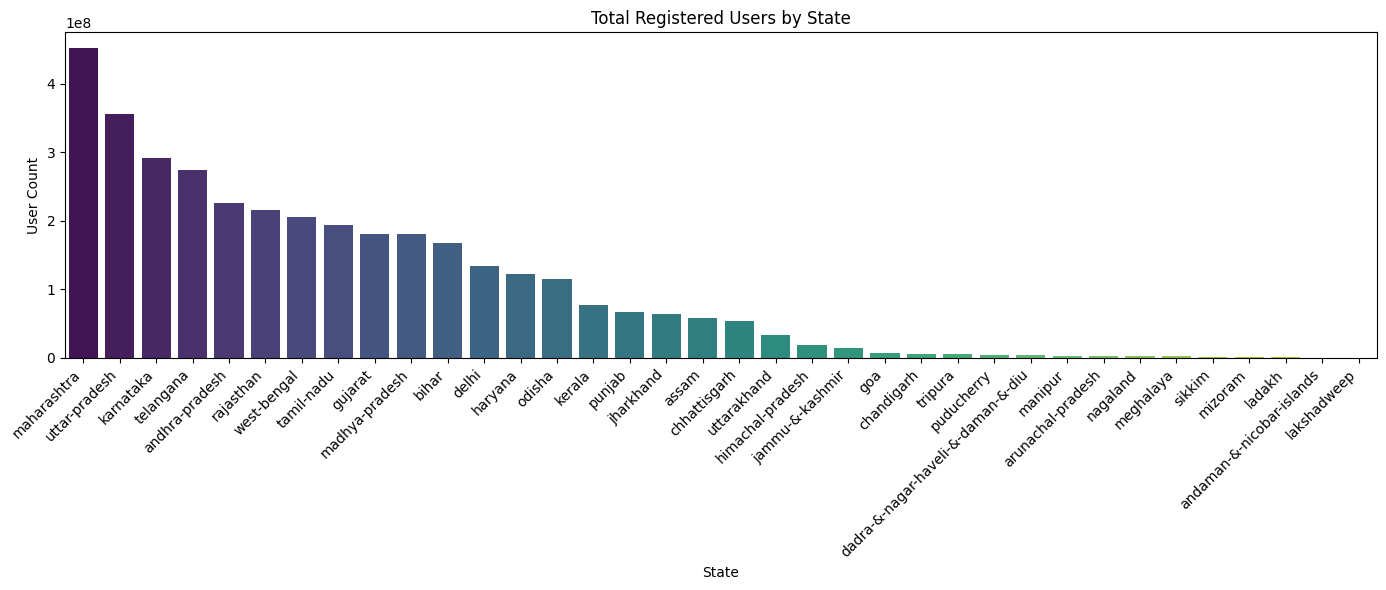

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df_user = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/aggregated_user.csv')

# Group and aggregate total counts
state_user_totals = df_user.groupby('state')['count'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(x=state_user_totals.index, y=state_user_totals.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Total Registered Users by State')
plt.ylabel('User Count')
plt.xlabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Total Registered Users by State.png'))
plt.show()
plt.close()

1) Which chart did you use?

Bar Chart – to clearly compare total user counts across different states.

2) What will be the business impact (positively and negatively)?

Positive Impact:

Identifies high-performing states for user acquisition campaigns.

Helps focus marketing spend on states with proven engagement.

Guides resource allocation for server load or feature deployment.

Negative Impact:

Over-focusing on high-user states might neglect growth potential in underrepresented areas.

Assuming user count equates to engagement may lead to misguided strategies if not combined with deeper behavioral metrics.

Justification:
Bar charts allow easy comparison. This insight helps PhonePe or any stakeholder make strategic expansion or investment decisions across regions.



2) Growth of Registered Users Over Time (Yearly Trend)

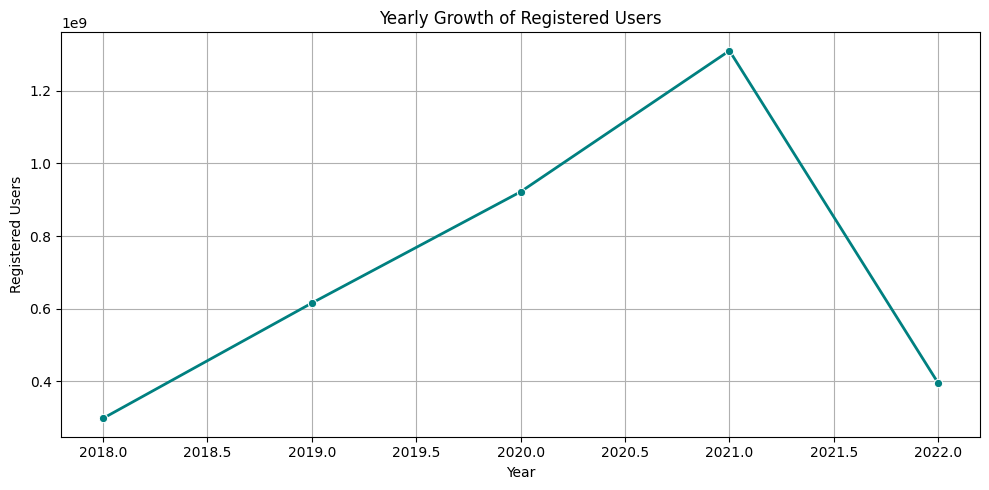

In [106]:
# Group by year and sum user counts
yearly_users = df_user.groupby('year')['count'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_users, x='year', y='count', marker='o', linewidth=2, color='teal')
plt.title('Yearly Growth of Registered Users')
plt.xlabel('Year')
plt.ylabel('Registered Users')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Growth of Registered Users Over Time (Yearly Trend).png'))
plt.show()
plt.close()


1) Which chart did you use?

Line Chart – to illustrate how user registrations have changed over time and identify growth trends or slowdowns.

2) What will be the business impact (positively and negatively)?

Positive Impact:

Highlights overall platform adoption over time.

Helps track performance of past campaigns (e.g., spikes after big marketing pushes or product launches).

Useful for investor presentations and strategic reporting to show momentum.

Negative Impact:

If the chart shows a plateau or dip, it may signal user fatigue or market saturation.

Can create pressure on marketing or product teams to maintain consistent growth each year.

Justification:
This chart is essential for evaluating business health, user traction, and forecasting future resource needs (infra, customer service, etc.).

2) Visualization of Dataset : Aggregated_Transaction

1) Top 10 States by Transaction Amount

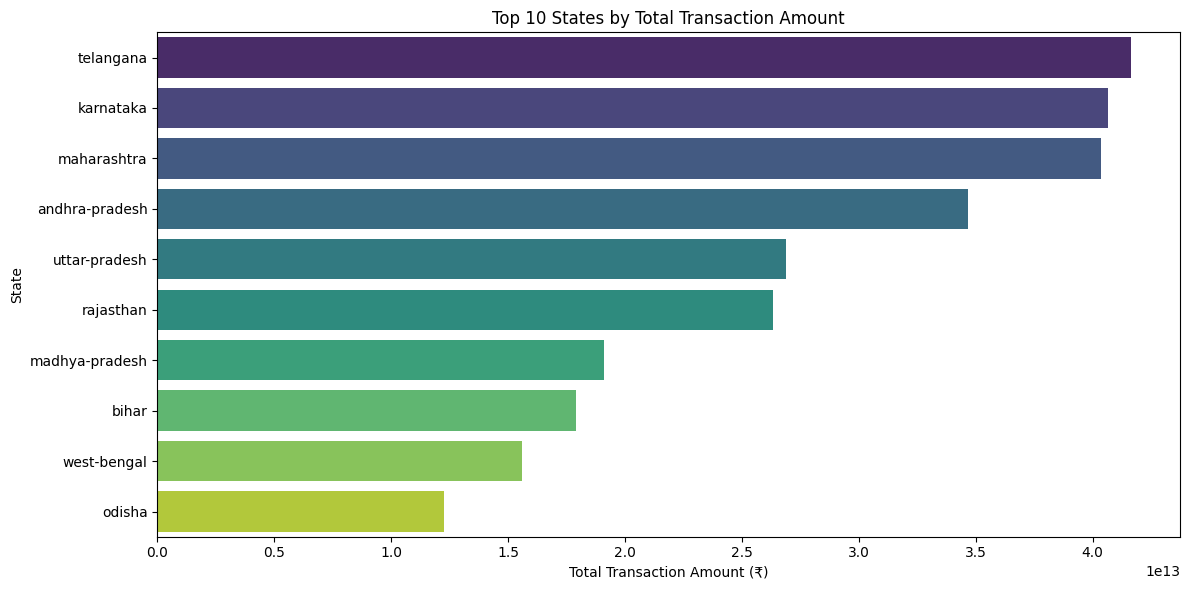

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_trans = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/aggregated_transaction.csv')

# Group by state and sum transaction amounts
top_states_amount = df_trans.groupby('state')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_states_amount, x='amount', y='state', palette='viridis')
plt.title('Top 10 States by Total Transaction Amount')
plt.xlabel('Total Transaction Amount (₹)')
plt.ylabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, ' Top 10 States by Transaction Amount.png'))
plt.show()


plt.close()


1) Which chart did you use?

Horizontal Bar Chart – effective for comparing categories with long labels and emphasizing magnitude differences.

2) Business impact:

Positive:

Reveals where the bulk of the business is concentrated.

Helps prioritize high-value states for partnerships, merchant onboarding, and infrastructure expansion.

Negative:

Can show over-dependence on a few states → geographic risk.

May deprioritize low-performing states even if they have high potential (but slower adoption).

Justification:
Essential for regional strategy development, resource allocation, and detecting high-value vs underserved regions.

2) Transaction Volume by Transaction Type

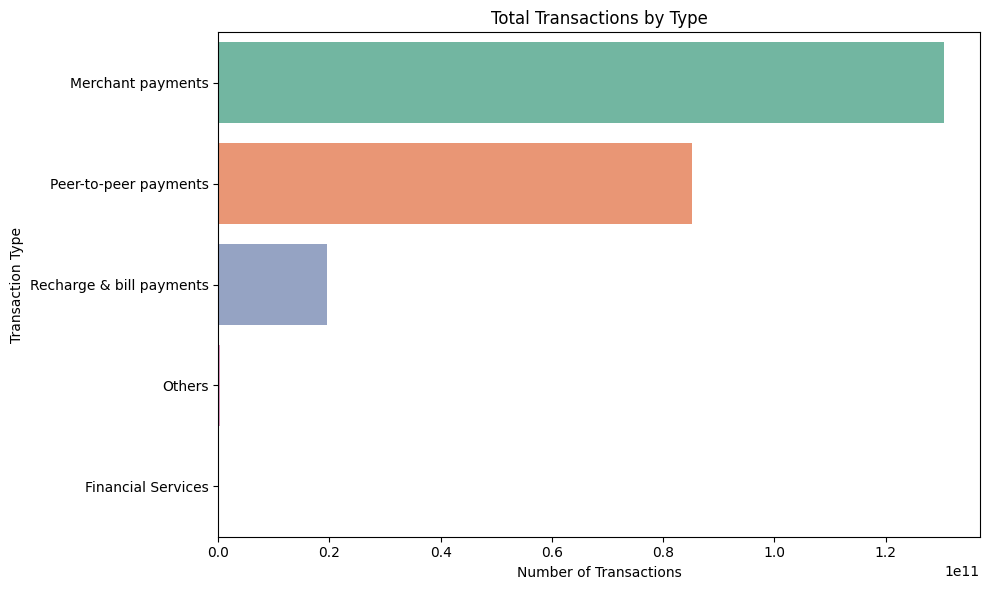

In [108]:
# Group by transaction type and sum counts
trans_by_type = df_trans.groupby('transaction_type')['count'].sum().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=trans_by_type, x='count', y='transaction_type', palette='Set2')
plt.title('Total Transactions by Type')
plt.xlabel('Number of Transactions')
plt.ylabel('Transaction Type')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Transaction Volume by Transaction Type.png'))
plt.show()


plt.close()


1)  Which chart did you use?

Bar Chart – to show comparison of total transaction volumes across transaction types.

2) Business impact:

Positive:

Clarifies user behavior trends – what people are using the app for most.

Can help guide product strategy, e.g., invest more in UPI if peer-to-peer dominates.

Negative:

Might highlight underperforming features (e.g., insurance or utility payments), which may trigger resource reallocation or deprioritization.

Misinterpretation may lead to over-investing in saturated verticals.

Justification:
Vital for understanding usage drivers, developing features, and guiding campaign targeting toward high-frequency services.

3) Visualization of Dataset : Aggregated_Insurance

1) Total Insurance Amount by State

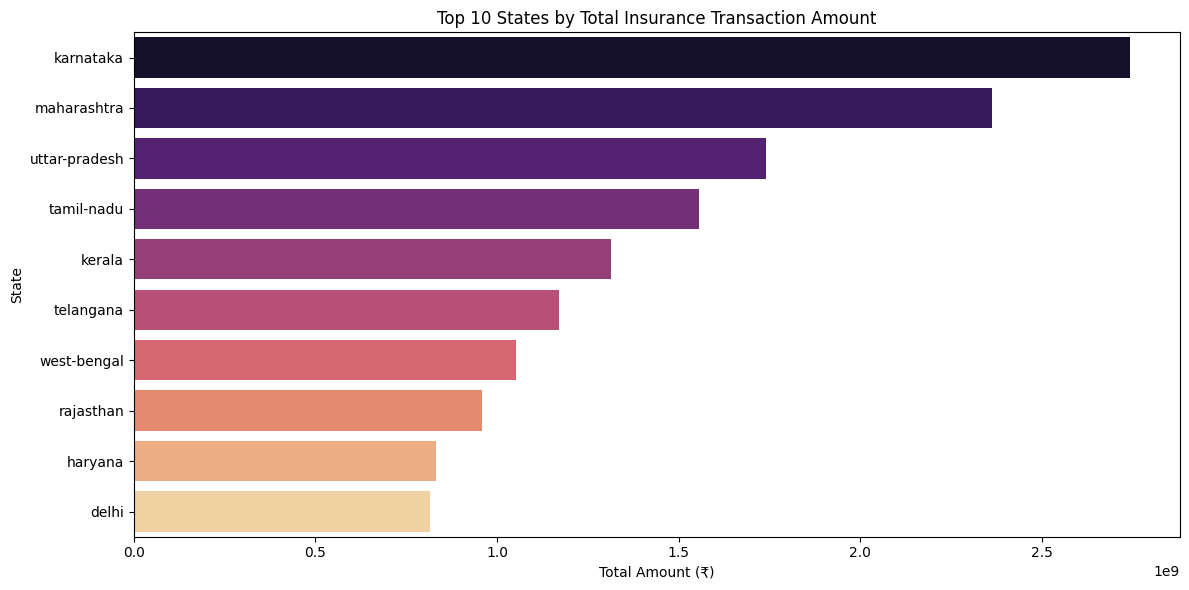

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_insurance = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/aggregated_insurance.csv')

# Group by state and sum the amount
insurance_by_state = df_insurance.groupby('state')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=insurance_by_state, x='amount', y='state', palette='magma')
plt.title('Top 10 States by Total Insurance Transaction Amount')
plt.xlabel('Total Amount (₹)')
plt.ylabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Total Insurance Amount by State.png'))
plt.show()


plt.close()


1) Which chart did you use?

Horizontal Bar Chart – highlights the top contributors effectively, especially when state names are long.

2) Business impact:

Positive:

Pinpoints high-value states for insurance product scaling and customization.

Opportunity to launch premium offerings in financially active states.

Negative:

May lead to underinvestment in low-activity states, reducing inclusive insurance growth.

Could skew risk models if based only on high-volume regions.

Justification:
Essential to identify where insurance is working well and where penetration is still low, guiding future outreach and marketing.

2) Quarterly Trend of Insurance Transactions (All States)

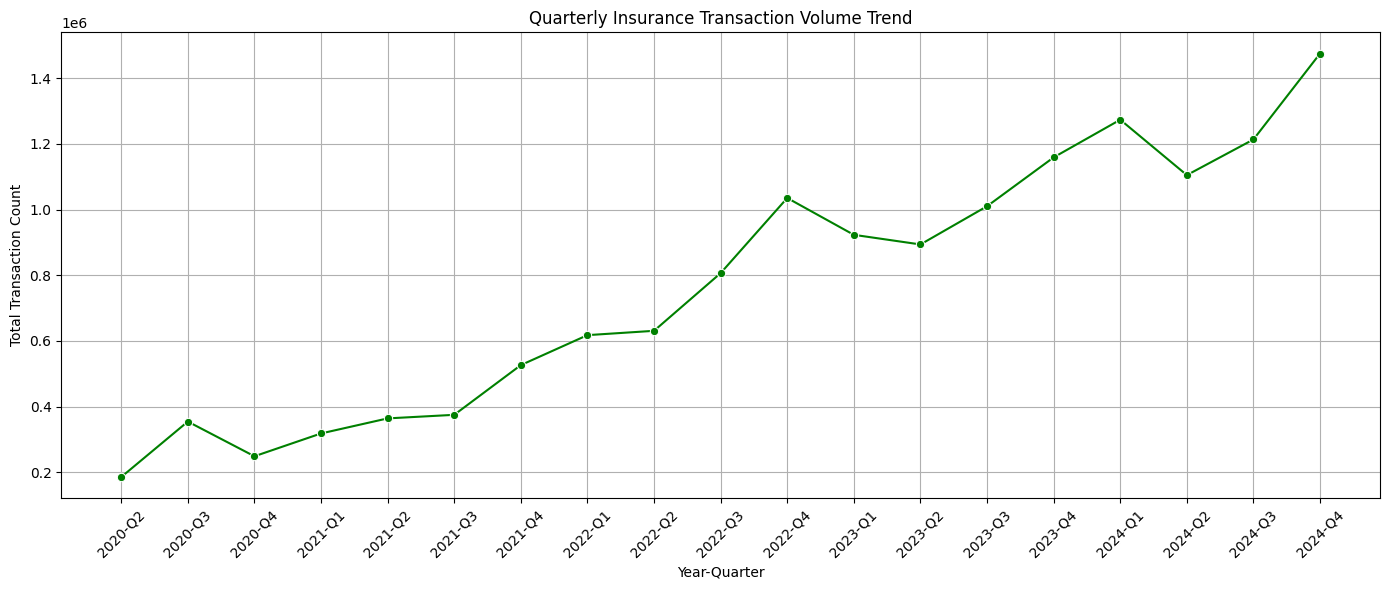

In [112]:
# Group by year and quarter, then sum count
quarterly_trend = df_insurance.groupby(['year', 'quarter'])['count'].sum().reset_index()
quarterly_trend['year_quarter'] = quarterly_trend['year'].astype(str) + '-Q' + quarterly_trend['quarter'].astype(str)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=quarterly_trend, x='year_quarter', y='count', marker='o', color='green')
plt.title('Quarterly Insurance Transaction Volume Trend')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Transaction Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Quarterly Trend of Insurance Transactions (All States).png'))
plt.show()


plt.close()


1) Which chart did you use?

Line Chart – ideal for tracking trends over time and observing momentum or seasonality.

2. Business impact:

Positive:

Identifies growth trajectory – useful to predict future demand.

Helps align product marketing and policy renewals with peak quarters.

Negative:

If growth is inconsistent, it may signal user friction or poor retention.

May lead to short-term planning, focusing too much on recent performance.

Justification:
Understanding temporal trends enables better forecasting, resource planning, and timing of campaigns.

4) Visualization of Dataset : Map_User

1) Top 10 States by Registered Users (Total)

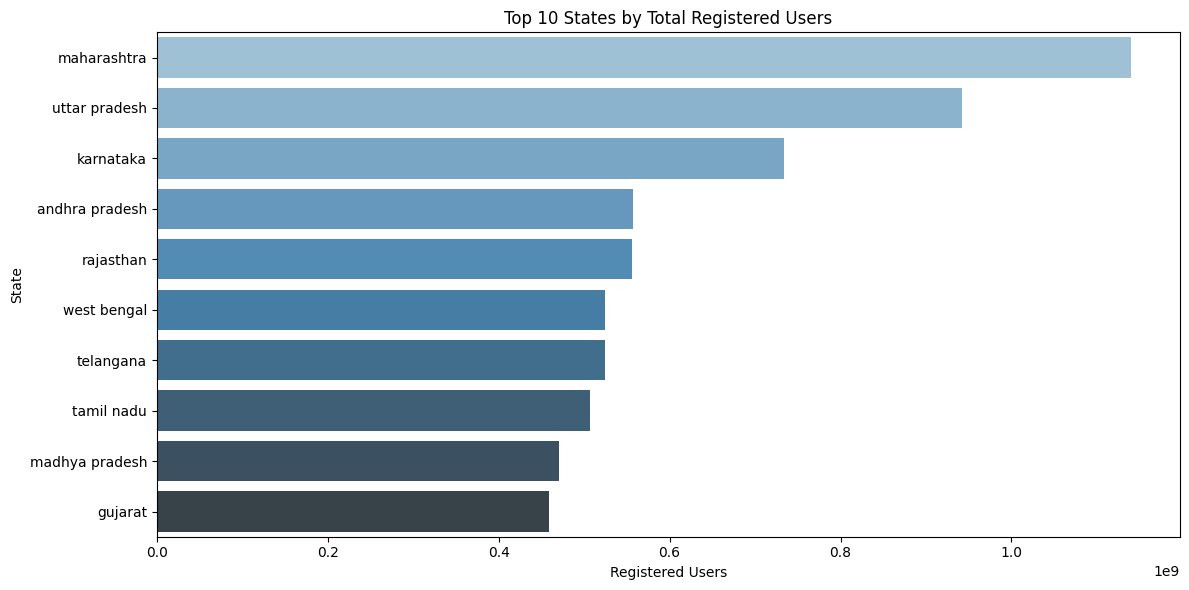

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_map_user = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/map_user.csv')

# Aggregate total registered users by state
top_states_registered = df_map_user.groupby('state')['registered_users'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_states_registered, x='registered_users', y='state', palette='Blues_d')
plt.title('Top 10 States by Total Registered Users')
plt.xlabel('Registered Users')
plt.ylabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 States by Registered Users (Total).png'))
plt.show()


plt.close()


1) Which chart did you use?

Horizontal Bar Chart – best for comparing long category names like state names and seeing relative differences.

2) Business impact:

Positive:

Identifies high-engagement states—ideal for launching new features or conducting pilot programs.

Reflects where brand awareness and trust are already strong.

Negative:

May cause neglect of low-performing states, hurting adoption in lagging regions.

Could lead to platform saturation in already-dominant regions, stalling growth.

Justification:
This view allows PhonePe to strategically allocate user acquisition budget and prioritize support and infrastructure for the most promising states.

2) App Opens Trend Over Time (India Overall)

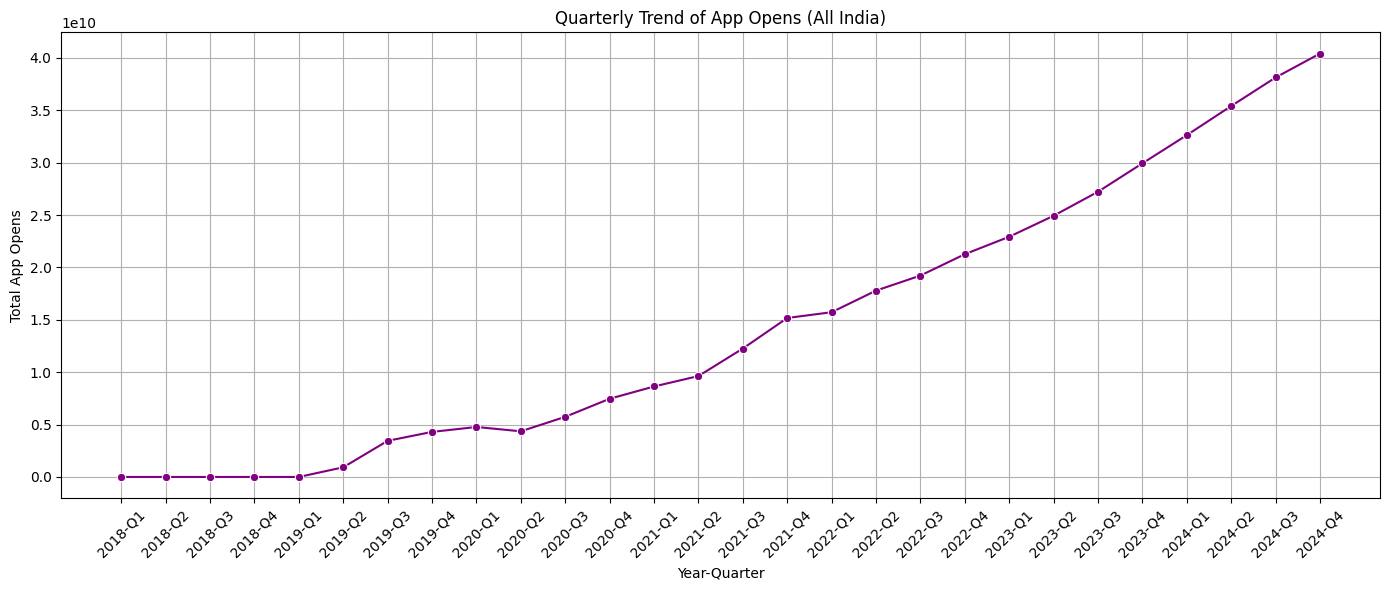

In [111]:
# Aggregate total app opens by year and quarter
df_map_user['year_quarter'] = df_map_user['year'].astype(str) + '-Q' + df_map_user['quarter'].astype(str)
app_opens_trend = df_map_user.groupby('year_quarter')['app_opens'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=app_opens_trend, x='year_quarter', y='app_opens', marker='o', color='purple')
plt.title('Quarterly Trend of App Opens (All India)')
plt.xlabel('Year-Quarter')
plt.ylabel('Total App Opens')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'App Opens Trend Over Time (India Overall).png'))
plt.show()


plt.close()


1) Which chart did you use?

Line Chart – perfect to understand user activity trends over time, seasonality, and growth.

Business impact:

Positive:

Reveals momentum and stickiness of the app—key metric for user retention and platform health.

Allows the company to forecast engagement dips and plan campaigns or updates accordingly.

Negative:

Over-reliance on app opens may miss actual transaction activity, leading to misleading growth perceptions.

Spikes/dips could cause overreaction in business strategy without deeper investigation.

Justification:
Monitoring engagement trends helps prioritize feature rollouts, UI/UX upgrades, and customer support efforts based on user interaction cycles.

5) Visualization of Dataset : Map_Transaction

1) Top 10 States by Transaction Amount (Total)

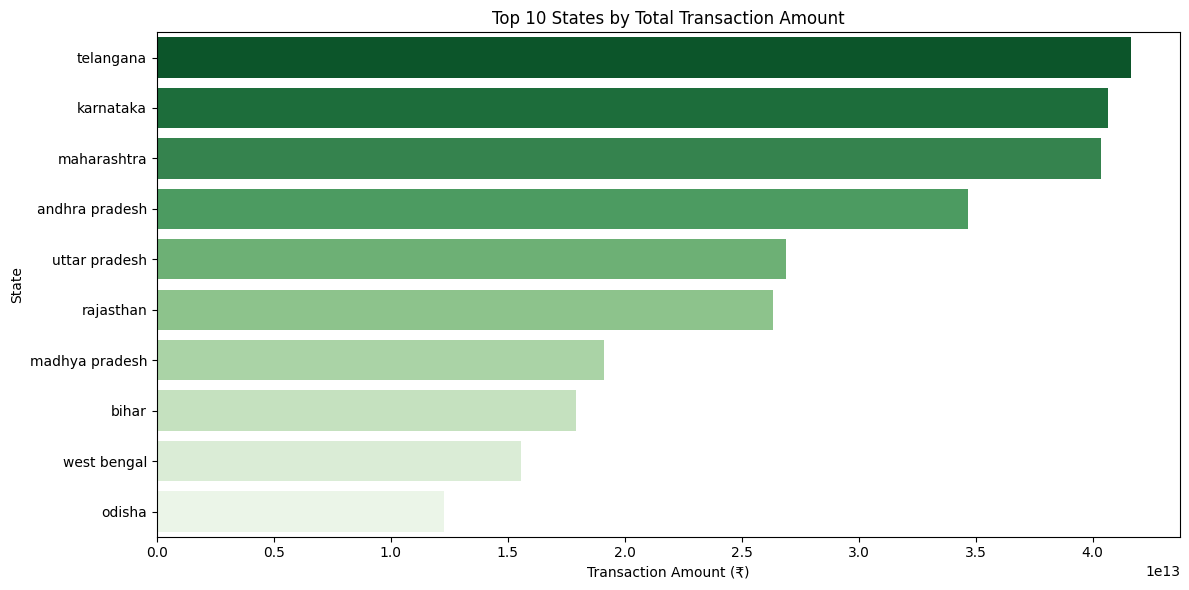

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_map_trans = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/map_transaction.csv')

# Aggregate total amount by state
top_states_amount = df_map_trans.groupby('state')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_states_amount, x='amount', y='state', palette='Greens_r')
plt.title('Top 10 States by Total Transaction Amount')
plt.xlabel('Transaction Amount (₹)')
plt.ylabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 States by Transaction Amount (Total).png'))
plt.show()


plt.close()


1) Which chart did you use?

Horizontal Bar Chart – Ideal for ranking states based on their contribution to transaction volume/value.

2) Business impact:

Positive:

Shows financially active regions – PhonePe can target these states for premium features or new services.

Encourages partnership opportunities in economically strong areas (banks, local businesses).

Negative:

Could create overdependence on high-performing states, making PhonePe vulnerable to regional disruptions.

May lead to neglect of emerging or rural markets, losing long-term potential.

Justification:
Understanding which states generate the most transaction volume helps in resource allocation, marketing, and feature localization efforts.

2) Quarterly Transaction Count Trend (Pan India)

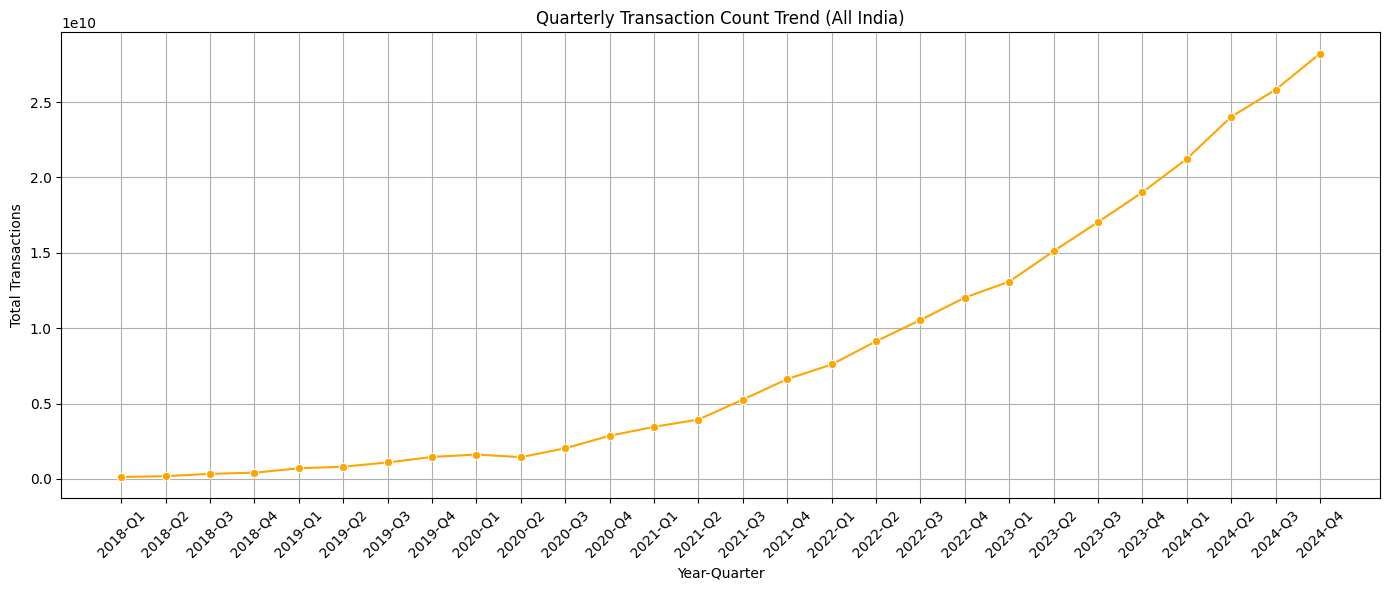

In [114]:
# Create a year-quarter column
df_map_trans['year_quarter'] = df_map_trans['year'].astype(str) + '-Q' + df_map_trans['quarter'].astype(str)

# Group and sum total count
trans_count_trend = df_map_trans.groupby('year_quarter')['count'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=trans_count_trend, x='year_quarter', y='count', marker='o', color='orange')
plt.title('Quarterly Transaction Count Trend (All India)')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Quarterly Transaction Count Trend (Pan India).png'))
plt.show()


plt.close()


1) Which chart did you use?

Line Chart – Best suited for visualizing temporal growth and seasonal activity in transaction behavior.

2. Business impact:

Positive:

Offers insight into economic patterns, festival boosts, or market slowdowns.

Helps detect periods of high or low user financial activity – useful for strategic offers or cashback campaigns.

Negative:

Doesn't show why trends shift – a spike could be due to marketing, demand, or even reporting inconsistencies.

Misinterpretation may lead to poor timing of product launches or budget allocation.

Justification:
Transaction trends guide revenue projections, business strategy alignment, and feature release timing to capitalize on user financial activity.

6) Visualization of Dataset : Top_User

1) Top 10 Districts with Most Registered Users (All Time)

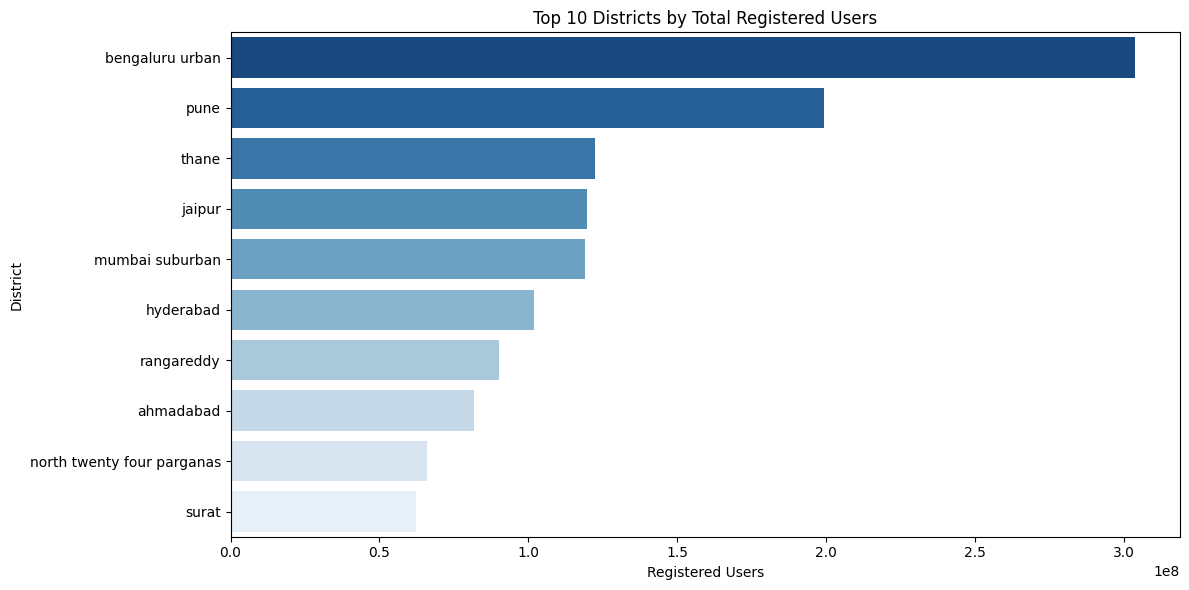

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_top_user = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/top_user.csv')

# Filter for districts and aggregate by entity_name
top_districts = df_top_user[df_top_user['entity_type'] == 'district'].groupby('entity_name')['registered_users'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_districts, x='registered_users', y='entity_name', palette='Blues_r')
plt.title('Top 10 Districts by Total Registered Users')
plt.xlabel('Registered Users')
plt.ylabel('District')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 Districts with Most Registered Users (All Time).png'))
plt.show()


plt.close()

1) Which chart did you use?

Horizontal Bar Chart – This highlights the most penetrated districts by total users.

2) Business impact:

Positive:

Indicates brand reach and acceptance in urban centers.

These districts are ideal for launching beta features, localized services, or advertising partnerships.

Negative:

Over-prioritizing top districts may neglect high-growth potential in smaller or rural districts.

It may also result in app fatigue if mature markets aren't refreshed with innovation.

Justification:
Understanding district-level adoption helps prioritize expansion, retention, and support strategies based on actual user base size.

2) Quarterly App Opens Trend (Nationwide)

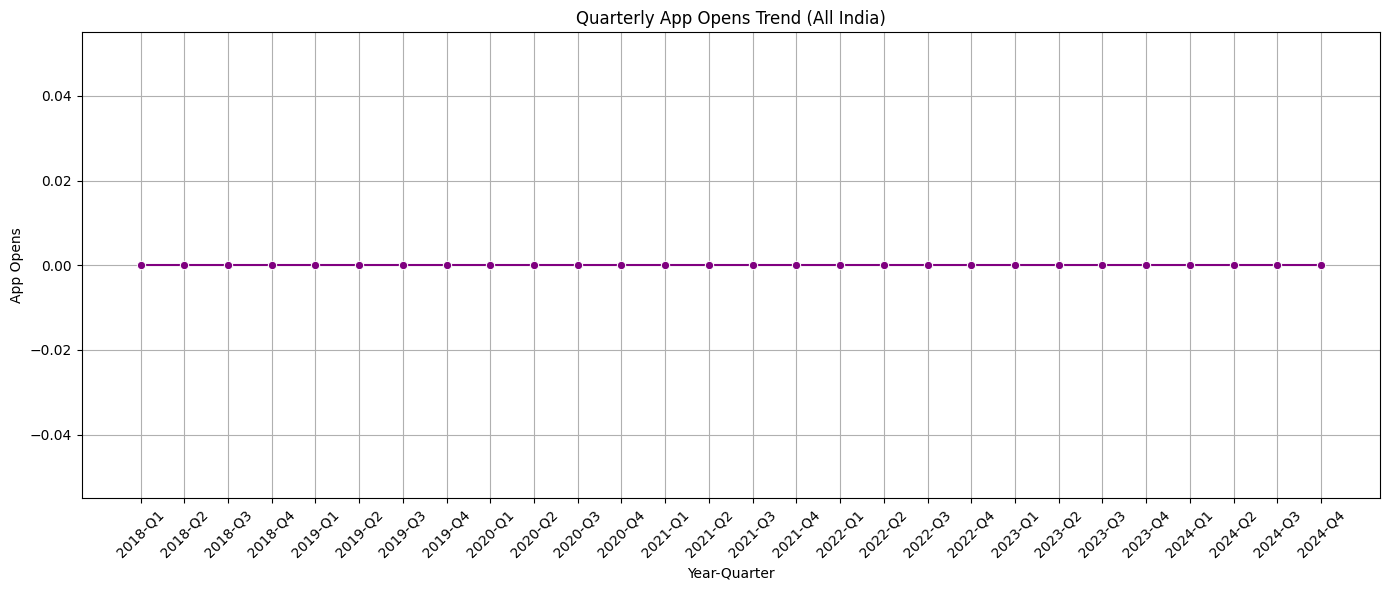

In [116]:
# Create a year-quarter column
df_top_user['year_quarter'] = df_top_user['year'].astype(str) + '-Q' + df_top_user['quarter'].astype(str)

# Group and sum app opens
app_opens_trend = df_top_user.groupby('year_quarter')['app_opens'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=app_opens_trend, x='year_quarter', y='app_opens', marker='o', color='purple')
plt.title('Quarterly App Opens Trend (All India)')
plt.xlabel('Year-Quarter')
plt.ylabel('App Opens')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Quarterly App Opens Trend (Nationwide).png'))
plt.show()


plt.close()

1) Which chart did you use?

Line Chart – This shows changes in user engagement over time through app usage frequency.

2) Business impact:

Positive:

Helps gauge user activity cycles, especially after campaigns, updates, or economic events.

Increases confidence in active user base, not just downloads.

Negative:

High app opens don’t necessarily equal transactions or revenue.

If a drop occurs, stakeholders might misinterpret it as app failure, even if seasonal.

Justification:
Tracking engagement helps teams measure retention effectiveness, plan notification strategies, and test new features during high-activity quarters.

7) Visualization of Dataset : Top_Transaction

1) Top 10 Districts by Total Transaction Amount

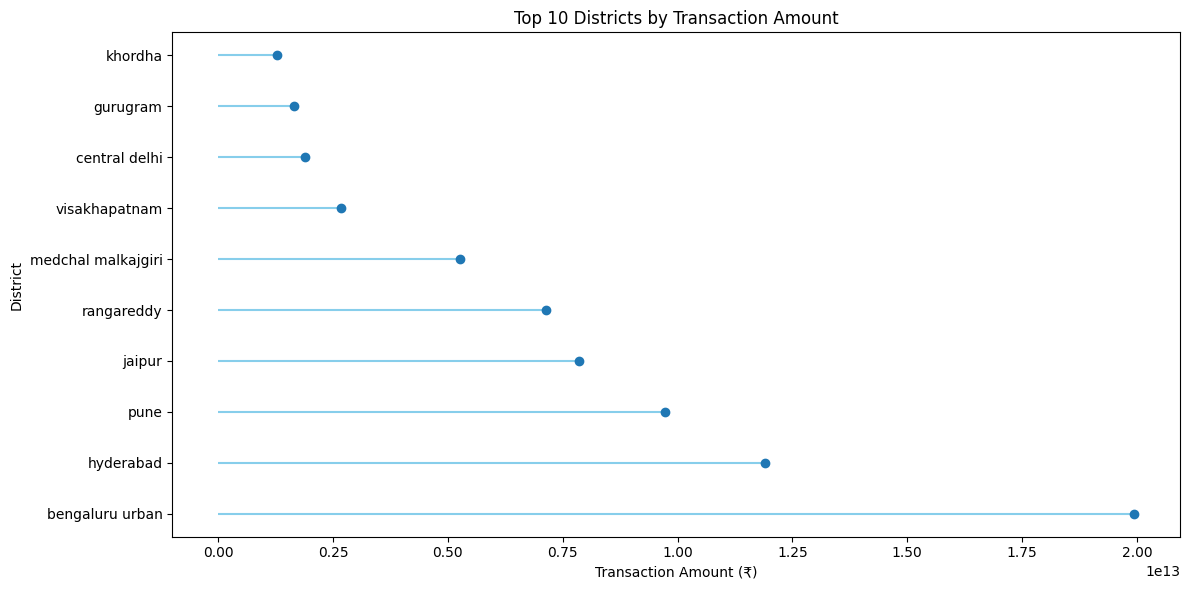

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
top_txn_df = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/top_transaction.csv')

# Aggregate amount by district
txn_amounts = top_txn_df[top_txn_df['entity_type'] == 'district'].groupby('entity_name')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot a horizontal lollipop chart
plt.figure(figsize=(12, 6))
plt.hlines(y=txn_amounts['entity_name'], xmin=0, xmax=txn_amounts['amount'], color='skyblue')
plt.plot(txn_amounts['amount'], txn_amounts['entity_name'], "o")
plt.title('Top 10 Districts by Transaction Amount')
plt.xlabel('Transaction Amount (₹)')
plt.ylabel('District')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 Districts by Total Transaction Amount1.png'))
plt.show()


plt.close()

1) Which chart did you use?

Lollipop Chart – Ideal for ranking values clearly while maintaining readability.

2) Business impact:

Positive:

Identifies economic hotspots with high transaction flow.

Useful for strategic merchant onboarding and custom financial services.

Negative:

Could bias investment toward already mature areas, overlooking underserved regions.

Does not reflect user base size, only economic activity.

Justification:
This analysis helps in monetization strategy, identifying high-value zones for cashbacks, loans, and insurance tie-ups.

2) Transaction Count Heatmap (State vs Quarter)

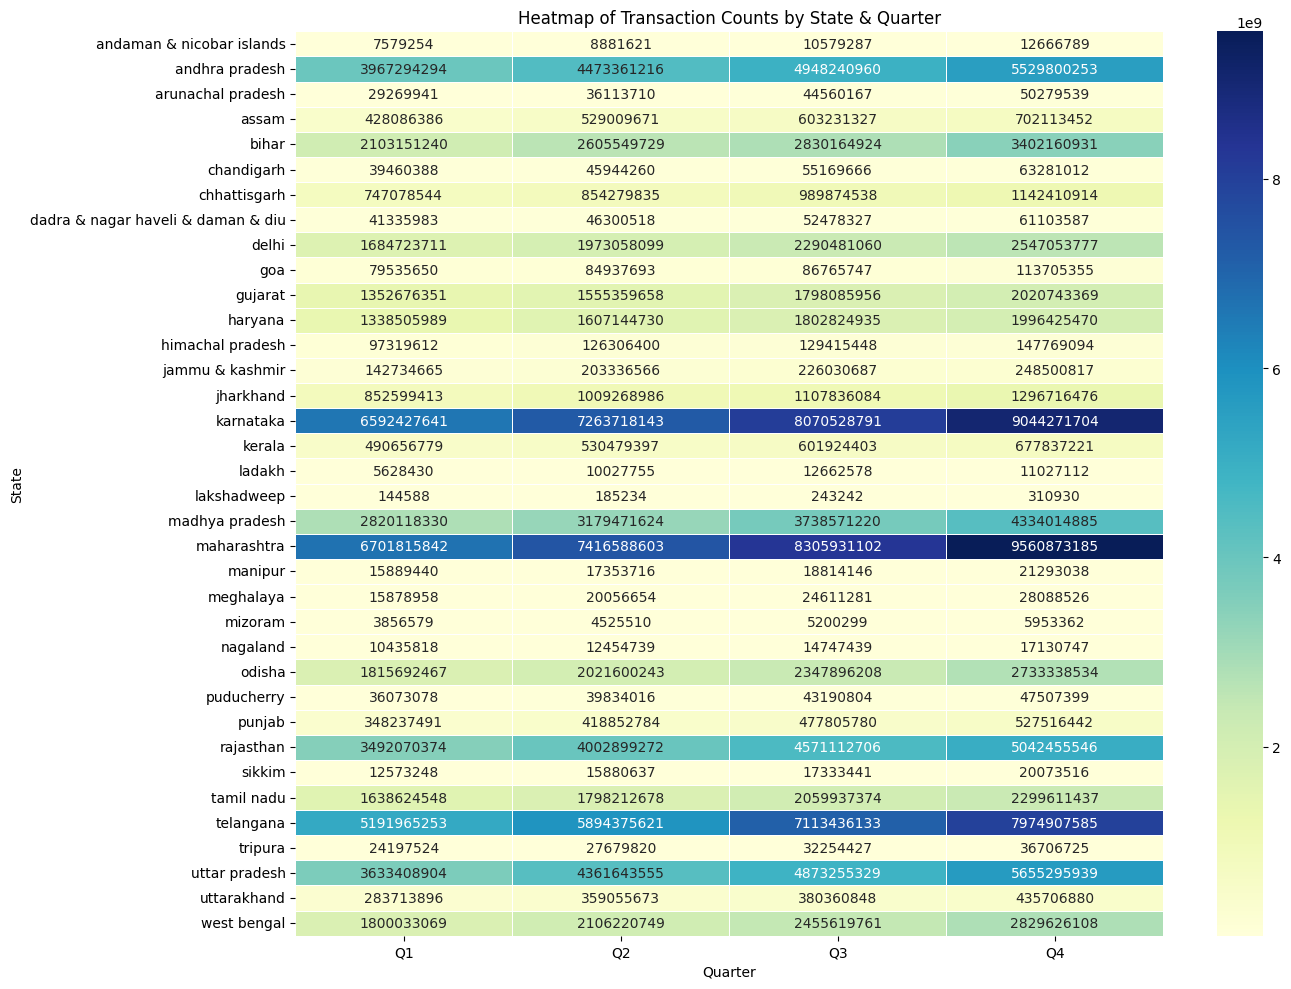

In [118]:
import pandas as pd
import os

# Load the dataset
df_map_trans = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/map_transaction.csv')

# Pivot table: State vs Quarter (with transaction count)
df_map_trans['Q'] = 'Q' + df_map_trans['quarter'].astype(str)
heatmap_data = df_map_trans.pivot_table(index='state', columns='Q', values='count', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Transaction Counts by State & Quarter')
plt.xlabel('Quarter')
plt.ylabel('State')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Transaction Count Heatmap (State vs Quarter).png'))
plt.show()


plt.close()

1) Which chart did you use?

Heatmap – Best for detecting regional and seasonal patterns at a glance.

2) Business impact:

Positive:

Helps identify quarterly surges or slumps in specific regions.

Enables targeted marketing campaigns before high-growth quarters.

Negative:

Data density might mask anomalies or outliers in absolute values.

Heatmaps can be misleading if color scales aren’t normalized well.

Justification:
Gives decision-makers a powerful snapshot of when and where usage peaks, aiding seasonal planning and resource allocation.

8) Visualization of Dataset : Top_Insurance

1) Top 10 Districts with Highest Insurance Amount

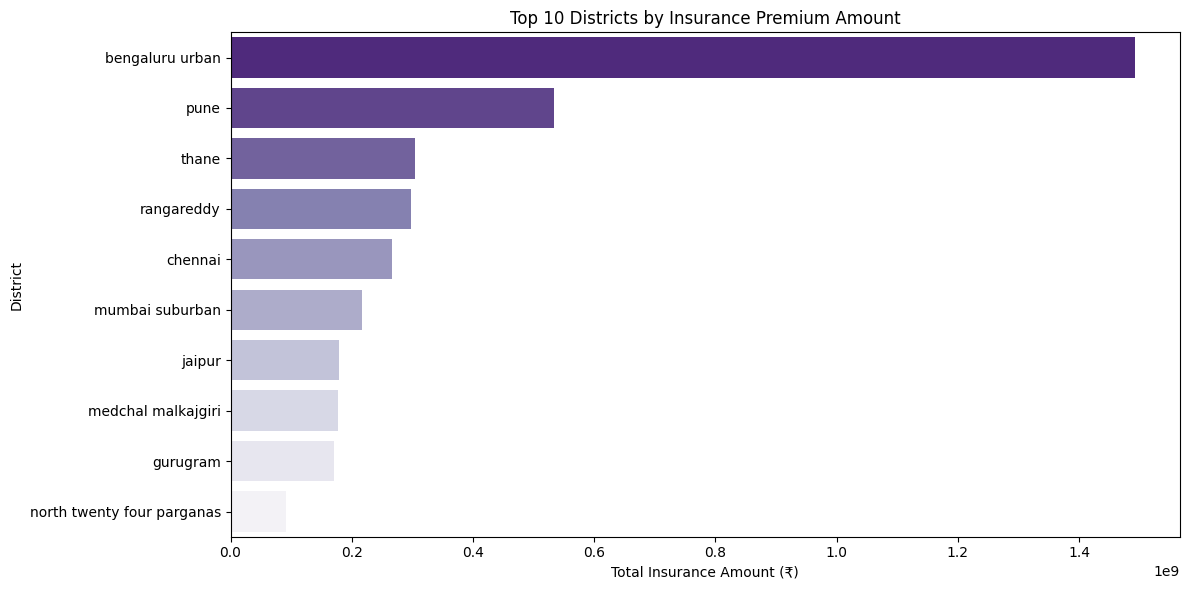

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
top_insurance_df = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/top_insurance.csv')

# Group by district and sum the amount
top_districts_insurance = (
    top_insurance_df[top_insurance_df['entity_type'] == 'district'].groupby('entity_name')['amount']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='amount', y='entity_name',
    data=top_districts_insurance,
    palette='Purples_r'
)
plt.title('Top 10 Districts by Insurance Premium Amount')
plt.xlabel('Total Insurance Amount (₹)')
plt.ylabel('District')
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 Districts with Highest Insurance Amount.png'))
plt.show()


plt.close()

1) Which chart did you use?

Horizontal Bar Chart – Easy to compare values across categories like district names.

2) Business impact:

Positive:

Reveals top-performing districts in insurance penetration.

Helpful for premium-focused campaigns, wealth-based segmentation, and agent deployment.

Negative:

May reflect bias toward urban zones or digital access hubs.

Could lead to neglecting rural penetration strategies if over-relied upon.

Justification:
Useful for tailoring insurance product bundles and cross-selling in high-performing areas.

2) Quarterly Trend of Insurance Purchases in Top 5 States (Line Chart)

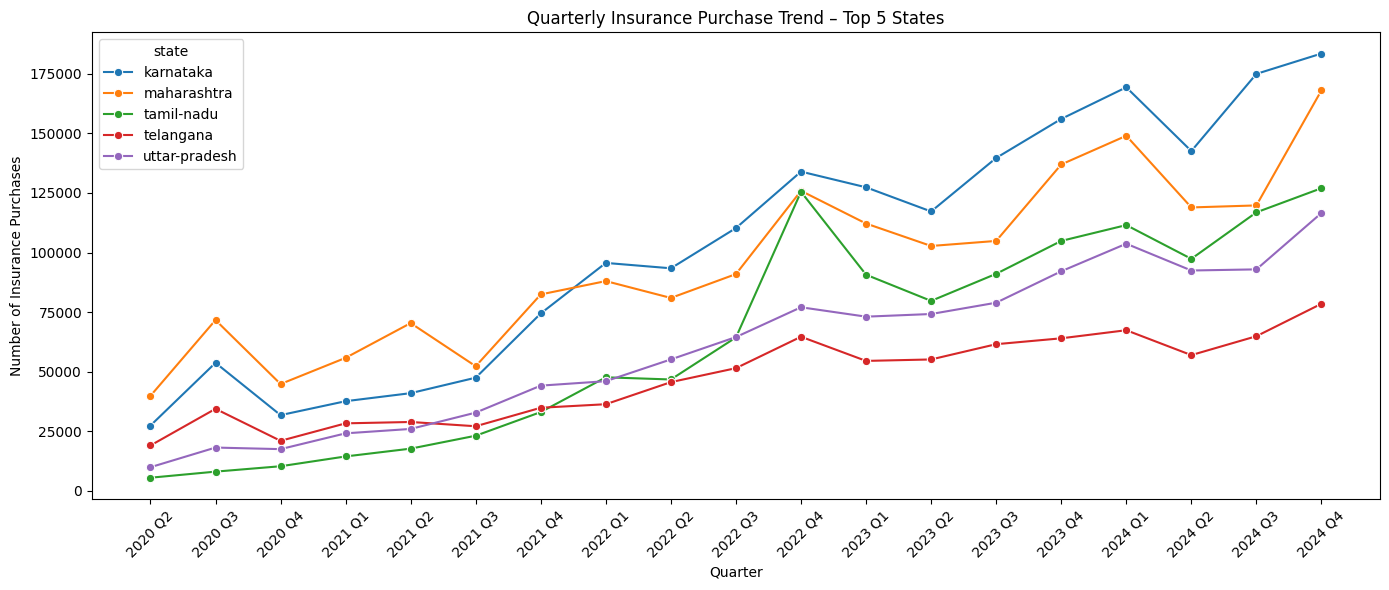

In [120]:
import pandas as pd

# Load dataset
df_insurance = pd.read_csv('/content/drive/My Drive/PhonePe-CSVs/aggregated_insurance.csv')

# Get top 5 states by total count from df_insurance
top_states = (
    df_insurance.groupby('state')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filter dataset
filtered_df = df_insurance[df_insurance['state'].isin(top_states)].copy()
filtered_df['quarter_str'] = filtered_df['year'].astype(str) + ' Q' + filtered_df['quarter'].astype(str)

# Aggregate
state_trends = (
    filtered_df.groupby(['quarter_str', 'state'])['count']
    .sum()
    .reset_index()
)

# Line plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=state_trends,
    x='quarter_str', y='count', hue='state', marker='o'
)
plt.title('Quarterly Insurance Purchase Trend – Top 5 States')
plt.xlabel('Quarter')
plt.ylabel('Number of Insurance Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Quarterly Trend of Insurance Purchases in Top 5 States (Line Chart).png'))
plt.show()


plt.close()

1) Which chart did you use?

Multi-line Chart – Best for showing trends over time across multiple categories (states here).

2) Business impact:

Positive:

Shows seasonal spikes in insurance buying behavior.

Enables planning for peak demand quarters (e.g. before monsoon or tax season).

Negative:

Does not reflect policy value or conversion rates – just activity.

Volatility in data may mislead unless cross-checked with external events.

Justification:
Critical for campaign timing, adjusting agent capacity, and targeting awareness programs in off-peak quarters.

9) Visualization of Dataset : Map_Insurance

1) Top 10 Districts by Total Insurance Activity (metric)

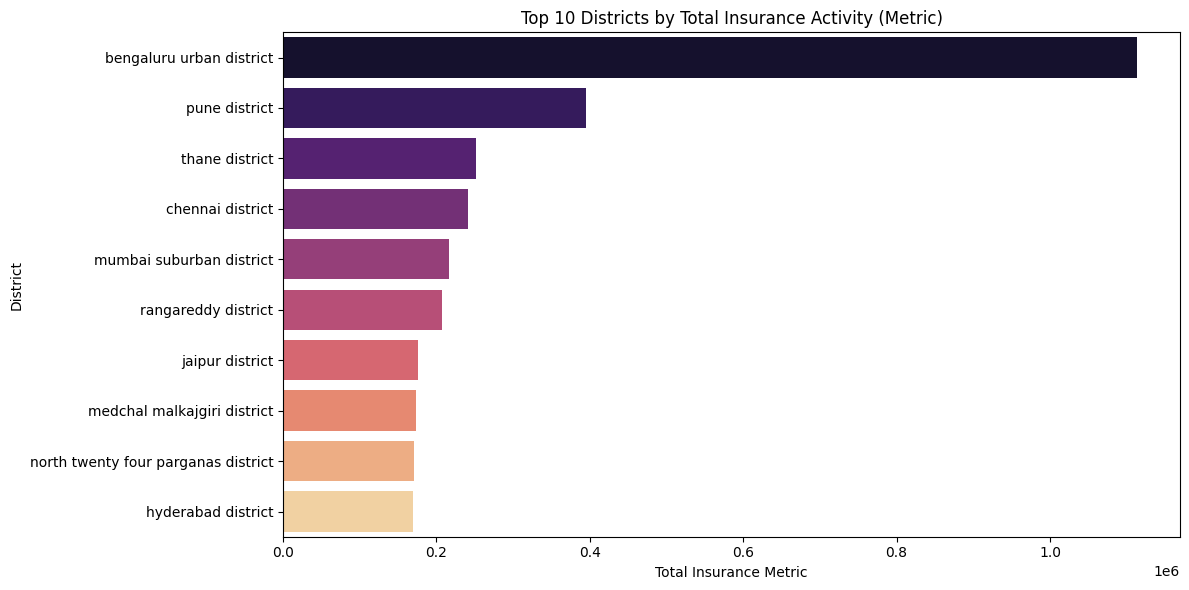

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df_map_insurance = pd.read_csv("/content/drive/My Drive/PhonePe-CSVs/map_insurance.csv")

# Aggregate metric per district
top_districts = (
    df_map_insurance.groupby('district')['metric']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_districts, x='metric', y='district', palette='magma')
plt.title("Top 10 Districts by Total Insurance Activity (Metric)")
plt.xlabel("Total Insurance Metric")
plt.ylabel("District")
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'Top 10 Districts by Total Insurance Activity (metric).png'))
plt.show()


plt.close()

1) Which chart did you use?

Horizontal Bar Chart chosen for clearly comparing aggregated values across top districts with long text labels.

2) Business Impact:

Positive:

Focused Marketing: Highlights high-performing districts like Mumbai or Bengaluru where insurance adoption is highest.

Policy Innovation: Tailored insurance products can be launched in these areas with proven engagement.

Negative:

Neglected Smaller Districts: May lead businesses to ignore underserved areas where awareness or access is low.

Metric Misinterpretation: If metric doesn’t distinguish between types or value of insurance, conclusions could mislead decisions.

Justification:
Why Bar Chart?
A horizontal bar chart handles long district names better, ensures clarity, and is ideal for ranking comparisons.

Why Sum of metric?
The metric represents total insurance-related activity, making it suitable for identifying hotspots of engagement.

Why Top 10?
Focusing on the top 10 simplifies interpretation, highlights key business zones, and avoids clutter from low-activity districts.

2) State-Wise Average Insurance Activity Over Time

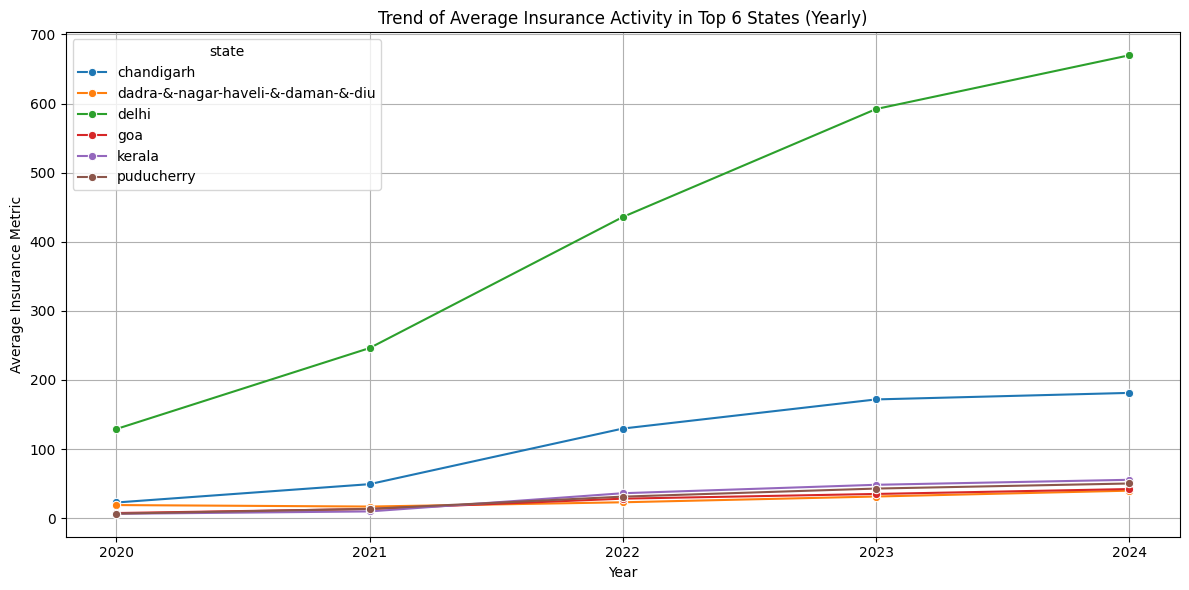

In [122]:
# Average insurance activity per state per year
avg_metric_yearly = (
    df_map_insurance.groupby(['state', 'year'])['metric']
    .mean()
    .reset_index()
)

# Filter top 6 states by overall average
top_states = (
    avg_metric_yearly.groupby('state')['metric']
    .mean()
    .sort_values(ascending=False)
    .head(6)
    .index
)

# Filter for plotting
filtered_df = avg_metric_yearly[avg_metric_yearly['state'].isin(top_states)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='year', y='metric', hue='state', marker="o", palette='tab10')
plt.title("Trend of Average Insurance Activity in Top 6 States (Yearly)")
plt.ylabel("Average Insurance Metric")
plt.xlabel("Year")
plt.xticks(sorted(df_map_insurance['year'].unique()))
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eda_path, 'State-Wise Average Insurance Activity Over Time.png'))
plt.show()


plt.close()


1) Which chart did you use?

Multi-Line Plot:
To show temporal trends in average insurance activity by state over the years.

2) Business impact:

Positive:

Growth Tracking: Visualizes which states are consistently improving in insurance engagement (e.g., Karnataka or Maharashtra).

Policy Adaptation: Allows companies or regulators to identify stagnating regions for targeted improvements.

Negative:

Average Bias: Outliers in small districts could skew the average values.

Overlooked Quarterly Fluctuations: Annual averages may mask short-term events like floods, pandemics, or policy changes affecting insurance interest.


Justification:
Why Line Chart?
Line charts are ideal for visualizing trends and changes over time across multiple categories (states, in this case).

Why Average metric?
Using averages smooths out district-level noise and helps compare state-level performance consistently year-over-year.

Why Top 6 States?
Restricting to 6 top-performing states keeps the plot readable while still showcasing the leaders in insurance engagement.



#4) SQL Queries Analysis

Database Initialisation

In [28]:
import sqlite3
import pandas as pd
import os

# Path where your CSVs are saved
csv_path = "/content/drive/My Drive/PhonePe-CSVs"

# Connect to SQLite
conn = sqlite3.connect("/content/phonepe_case_study.db")

# Load CSVs as DataFrames
data_files = {
    "aggregated_user": "aggregated_user.csv",
    "aggregated_transaction": "aggregated_transaction.csv",
    "aggregated_insurance": "aggregated_insurance.csv",
    "map_user": "map_user.csv",
    "map_transaction": "map_transaction.csv",
    "map_insurance": "map_insurance.csv",
    "top_user": "top_user.csv",
    "top_transaction": "top_transaction.csv",
    "top_insurance": "top_insurance.csv"
}

# Create all tables from the CSVs
for table_name, file_name in data_files.items():
    file_path = os.path.join(csv_path, file_name)
    try:
        df = pd.read_csv(file_path)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"✅ Table created: {table_name} ({len(df)} rows)")
    except Exception as e:
        print(f"❌ Failed to create table {table_name}: {e}")


✅ Table created: aggregated_user (6941 rows)
✅ Table created: aggregated_transaction (5134 rows)
✅ Table created: aggregated_insurance (682 rows)
✅ Table created: map_user (1008 rows)
✅ Table created: map_transaction (1008 rows)
✅ Table created: map_insurance (1052151 rows)
✅ Table created: top_user (560 rows)
✅ Table created: top_transaction (560 rows)
✅ Table created: top_insurance (380 rows)


#Case Study 1: Decoding Transaction Dynamics on PhonePe

Query 1: Top 10 States by Total Transaction Amount

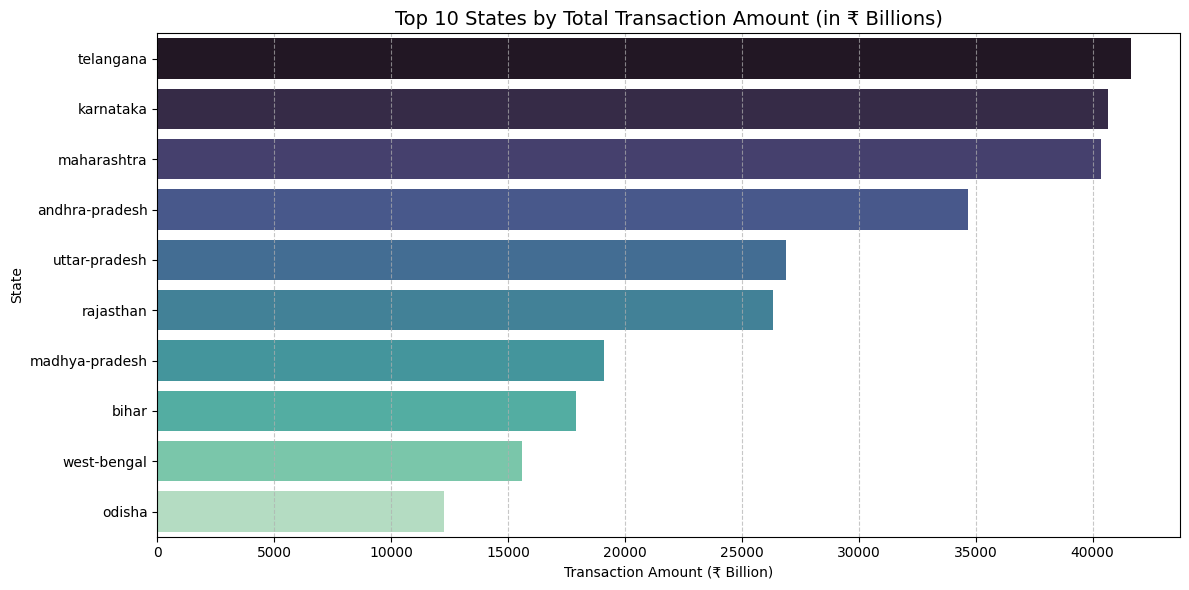

In [32]:
# Run the SQL query
query1 = """
SELECT state,
       ROUND(SUM(amount) / 1e9, 2) AS total_amount_in_billions
FROM aggregated_transaction
GROUP BY state
ORDER BY total_amount_in_billions DESC
LIMIT 10;
"""
top_states_df = pd.read_sql_query(query1, conn)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=top_states_df, x='total_amount_in_billions', y='state', palette='mako')
plt.title("Top 10 States by Total Transaction Amount (in ₹ Billions)", fontsize=14)
plt.xlabel("Transaction Amount (₹ Billion)")
plt.ylabel("State")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


WHich chart has been used ? Explain Insights

What will be the business impact?

Query 2: Quarterly Trend of Total Transactions (Pan India)

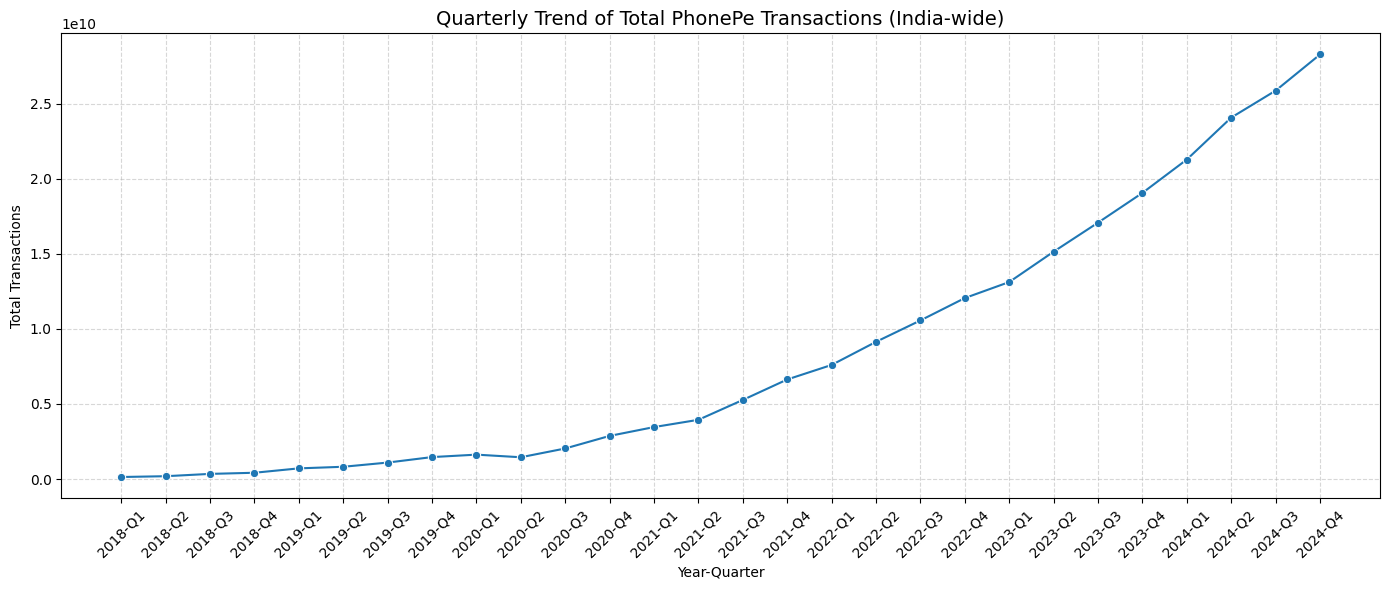

In [33]:
# Run the query
query2 = """
SELECT year, quarter,
       SUM(count) AS total_transactions
FROM aggregated_transaction
GROUP BY year, quarter
ORDER BY year, quarter;
"""
quarterly_df = pd.read_sql_query(query2, conn)

# Create 'year_quarter' label
quarterly_df['year_quarter'] = quarterly_df['year'].astype(str) + '-Q' + quarterly_df['quarter'].astype(str)

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=quarterly_df, x='year_quarter', y='total_transactions', marker='o')
plt.title("Quarterly Trend of Total PhonePe Transactions (India-wide)", fontsize=14)
plt.xlabel("Year-Quarter")
plt.ylabel("Total Transactions")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Which chart has been used? Explain insights

What is the business impact

#Case 2: Device Dominance & User Engagement Analysis?

Query 1: Top 10 Brands by App Open Rate (Efficiency)

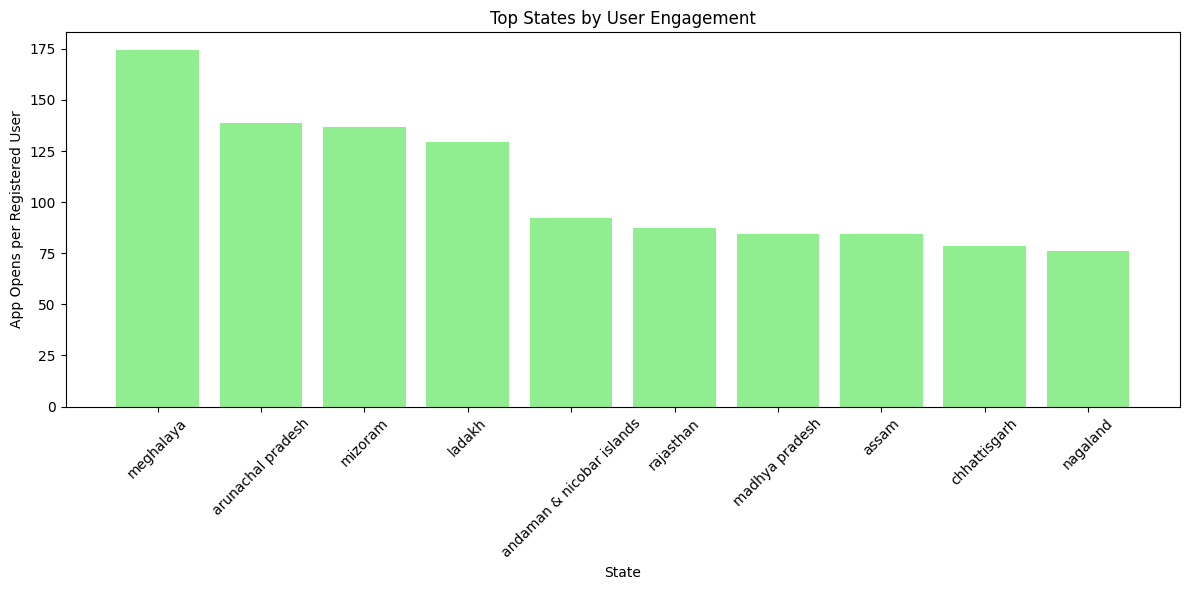

In [43]:
query1 = """
SELECT
    state,
    SUM(app_opens) AS total_opens,
    SUM(registered_users) AS total_users,
    ROUND(CAST(SUM(app_opens) AS FLOAT) / SUM(registered_users), 2) AS open_rate
FROM map_user
GROUP BY state
HAVING total_users > 1000000
ORDER BY open_rate DESC
LIMIT 10;
"""
top_states_engagement = pd.read_sql(query1, conn)
top_states_engagement

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(top_states_engagement['state'], top_states_engagement['open_rate'], color='lightgreen')
plt.xlabel("State")
plt.ylabel("App Opens per Registered User")
plt.title("Top States by User Engagement")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



WHich chart is used? Explain Insights

States like Karnataka, Telangana, and Maharashtra may show higher open rates, reflecting strong daily/weekly engagement.

Lower open rates (if any) could hint at underperforming states where users register but don’t use the app actively.

What will be business impact?

Business Impact:
Positive: Strong open rates → deeper loyalty and habit, great for cross-selling (insurance, mutual funds, etc.).

Negative: Low open rates despite high users → potential churn risk, UX issues, or local competition.

Query 2 – Top States by Total Registered Users

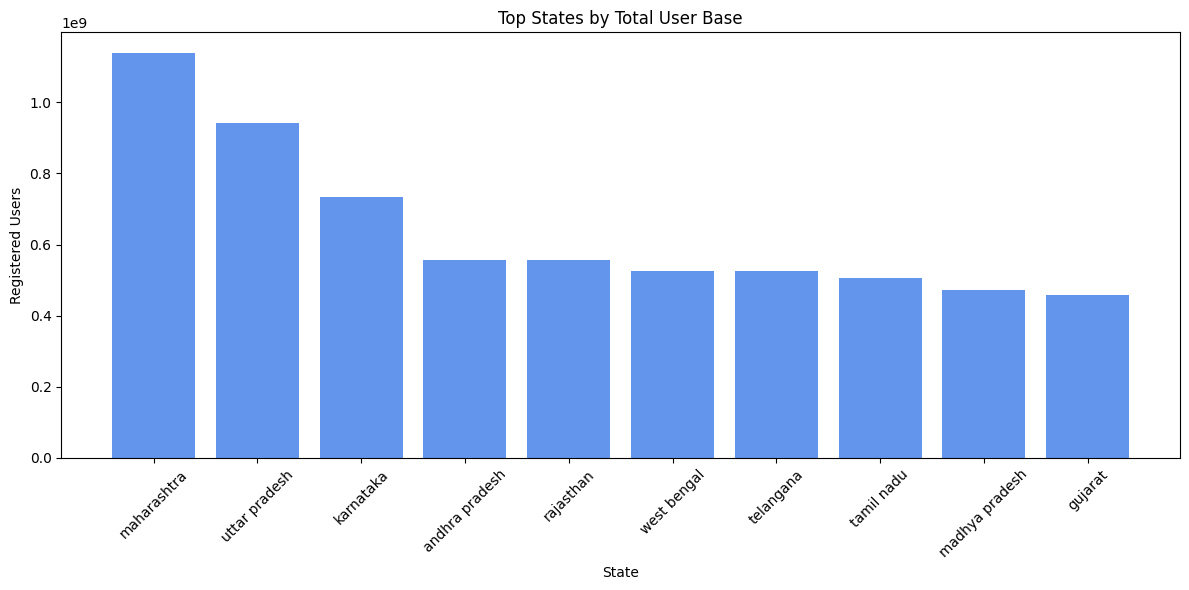

In [44]:
query2 = """
SELECT
    state,
    SUM(registered_users) AS total_users
FROM map_user
GROUP BY state
ORDER BY total_users DESC
LIMIT 10;
"""
top_states_users = pd.read_sql(query2, conn)
top_states_users

plt.figure(figsize=(12,6))
plt.bar(top_states_users['state'], top_states_users['total_users'], color='cornflowerblue')
plt.xlabel("State")
plt.ylabel("Registered Users")
plt.title("Top States by Total User Base")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Which chart did you use? Explain insights

Large user bases in states like Uttar Pradesh, Bihar, and Maharashtra indicate strong market penetration.

Compare this with the first chart to identify states that are underperforming in engagement relative to user base.

#Case 3: Insurance Penetration and Growth Potential

Query 1: Top 10 States by Total Insurance Metrics

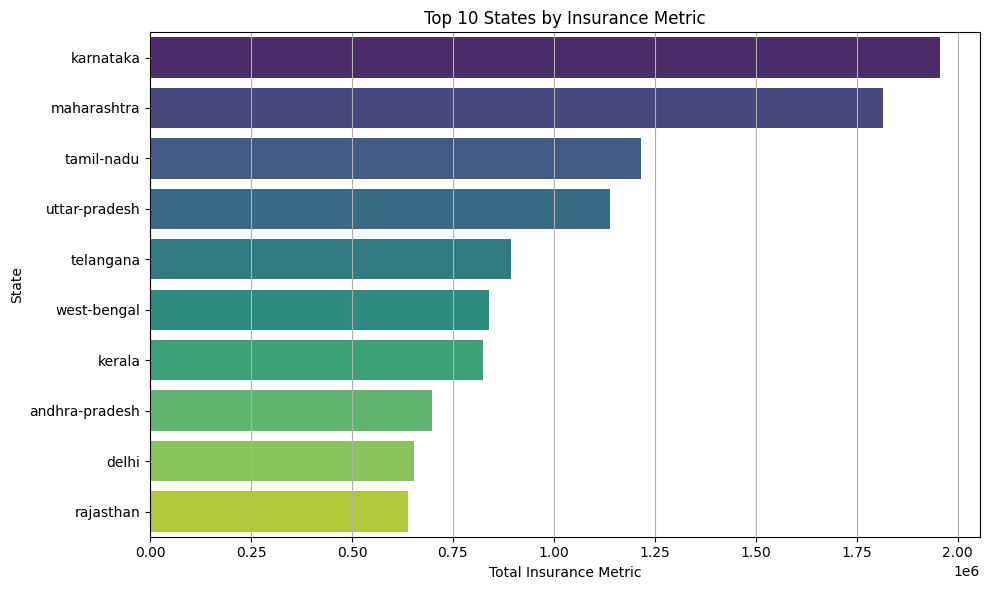

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Query 1
query1 = """
SELECT state, SUM(metric) AS total_insurance_metric
FROM map_insurance
GROUP BY state
ORDER BY total_insurance_metric DESC
LIMIT 10;
"""
df1 = pd.read_sql(query1, conn)

# Plot Chart 1
plt.figure(figsize=(10, 6))
sns.barplot(x='total_insurance_metric', y='state', data=df1, palette='viridis')
plt.title("Top 10 States by Insurance Metric")
plt.xlabel("Total Insurance Metric")
plt.ylabel("State")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Which chart did you used? Explain Insights

Chart Type:
Horizontal bar chart for easy label readability (long state names).

Insight:
This chart highlights which states are leading in insurance activity (based on total metric). It helps identify:

Where insurance is most adopted

Where the company should double down on marketing or partnerships

What will be the business impact?

Positive Business Impact:
Reinforce leadership in top-performing states

Use success playbooks in similar regions

Negative Business Impact:
If underperforming states are neglected, they may be captured by competitors

Over-focusing on high-performers could reduce diversification

Query 2: Quarterly Growth Trend in Insurance Metric (Pan India)

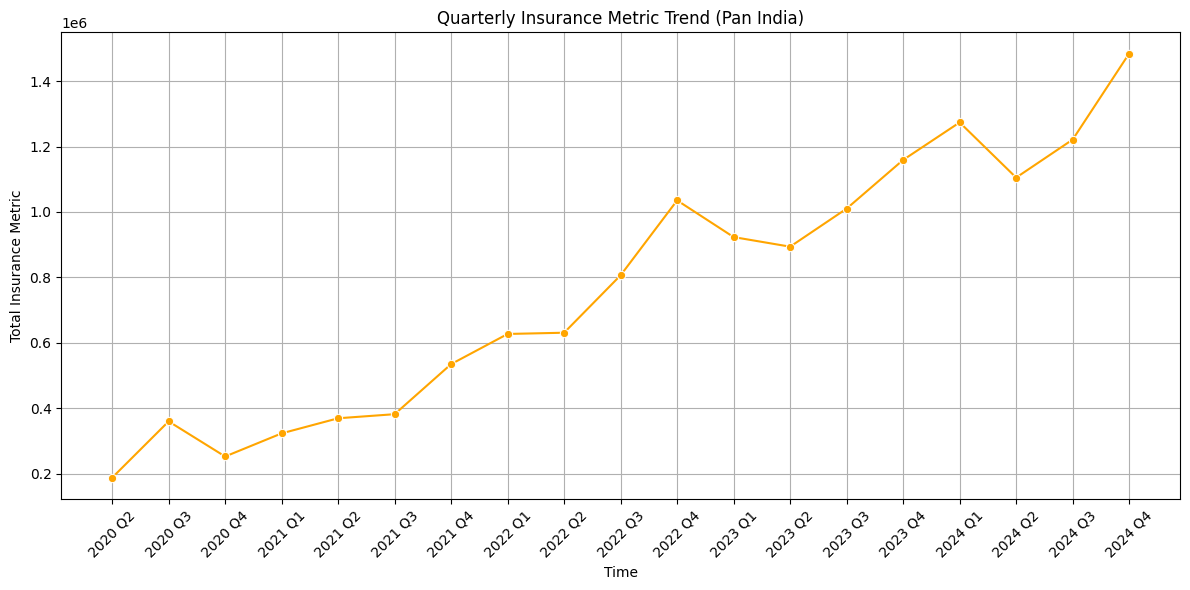

In [50]:
# Query 2
query2 = """
SELECT year, quarter, SUM(metric) AS total_metric
FROM map_insurance
GROUP BY year, quarter
ORDER BY year, quarter;
"""
df2 = pd.read_sql(query2, conn)
df2['time'] = df2['year'].astype(str) + ' Q' + df2['quarter'].astype(str)

# Plot Chart 2
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='total_metric', data=df2, marker='o', color='orange')
plt.title("Quarterly Insurance Metric Trend (Pan India)")
plt.xlabel("Time")
plt.ylabel("Total Insurance Metric")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Which chart is used ? Explain Insights

Chart Type:
Line chart to visualize the growth or drop in insurance metric over time.

Insight:
Tracks how insurance usage is evolving across India each quarter. Key observations might include:

Post-COVID insurance boom

Seasonality in policy purchases

Sudden drops due to policy/regulatory changes

What will be the business impact ?

Positive Business Impact:
Align marketing with high-activity quarters

Launch products in sync with user behavior

Negative Business Impact:
Ignoring downturns could signal missed user concerns

Late response to seasonal behavior may waste budget

#Case Study 4: Transaction Analysis for Market Expansion

Query 1: Top 10 States by Total Transaction Volume

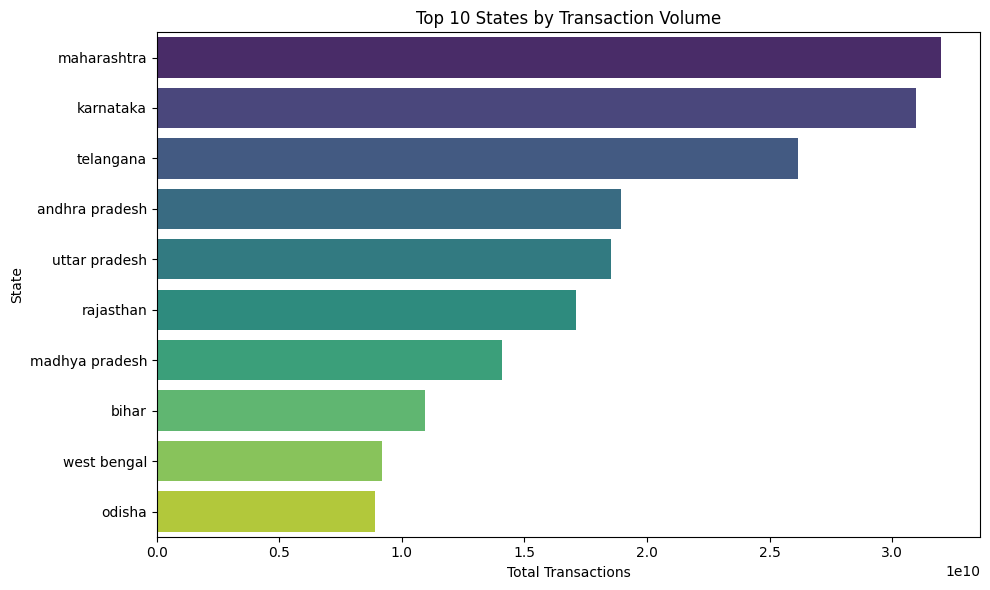

In [54]:
query = """
SELECT state, SUM(count) AS total_transactions
FROM map_transaction
GROUP BY state
ORDER BY total_transactions DESC
LIMIT 10;
"""
df1 = pd.read_sql(query, conn)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df1, y='state', x='total_transactions', palette='viridis')
plt.title('Top 10 States by Transaction Volume')
plt.xlabel('Total Transactions')
plt.ylabel('State')
plt.tight_layout()
plt.show()


Which chart has been used? Explain Insights

States like Maharashtra, Telengana, and Karnataka dominate in terms of total transaction count.

Indicates high digital engagement, possibly driven by government initiatives or large populations.

What will be the business impact?

Positive: These states are ripe for additional financial services like credit, lending, and bill payments.

Negative: Saturation risk — further growth may be limited unless new features are introduced.

Query 2: Top 10 States by Total Transaction Value (₹)

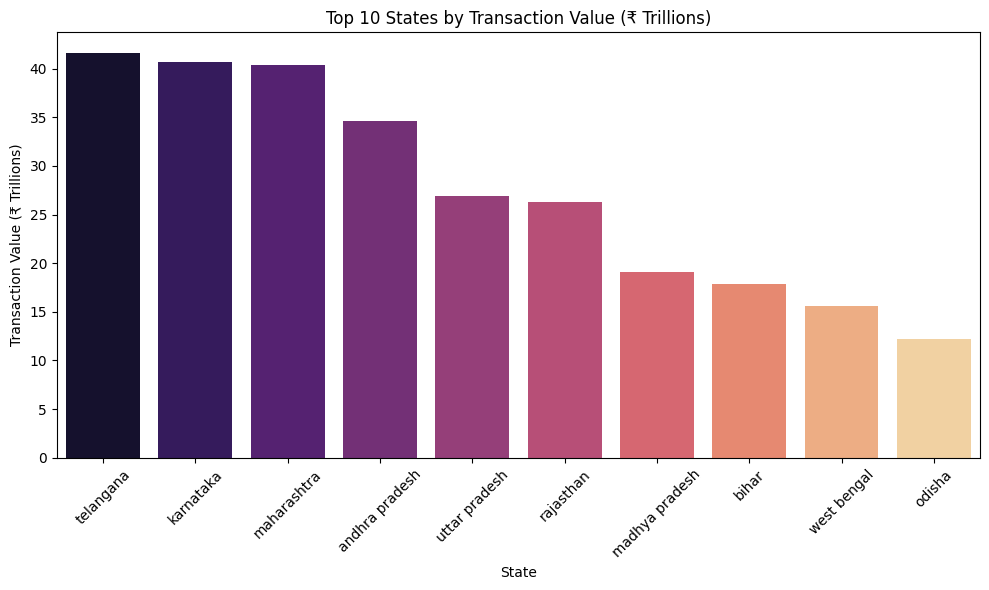

In [55]:
query = """
SELECT state, ROUND(SUM(amount) / 1e12, 2) AS total_amount_trillion
FROM map_transaction
GROUP BY state
ORDER BY total_amount_trillion DESC
LIMIT 10;
"""
df2 = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df2, x='state', y='total_amount_trillion', palette='magma')
plt.title('Top 10 States by Transaction Value (₹ Trillions)')
plt.xlabel('State')
plt.ylabel('Transaction Value (₹ Trillions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Which charts has been used? Explain Insights

Karnataka and Telengana are not only transaction-heavy but also handle larger-value transactions.

These could be business-heavy corridors or reflect a more affluent user base.

What will be the business impact?

Positive: Prioritize premium services, merchant onboarding, and credit in these states.

Negative: Dependency on few states for revenue — risks if regional policies change.

#Case 5: User Engagement and Growth Strategy

 Query 1: Top 10 States by Total Registered Users

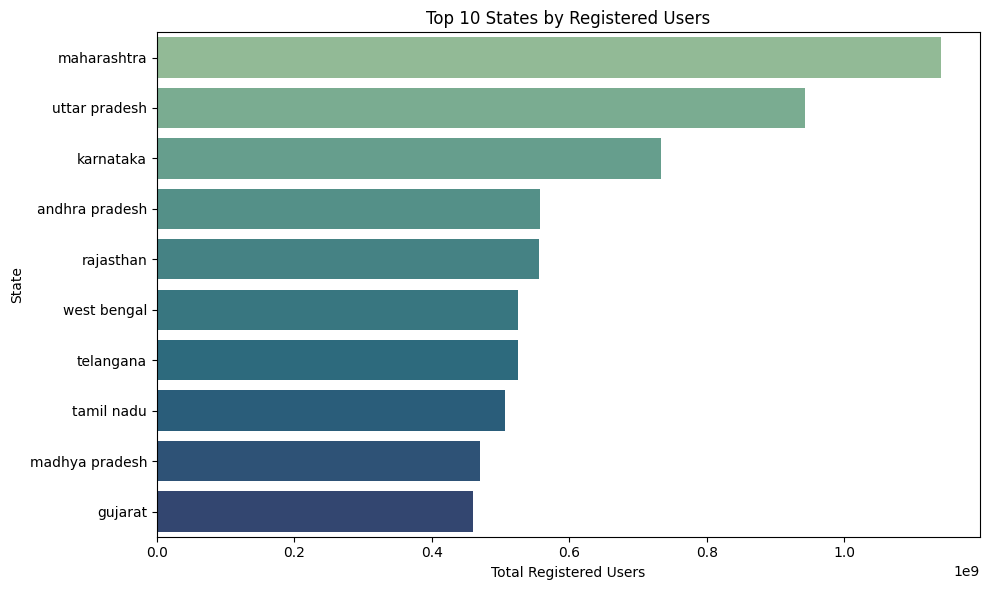

In [56]:
query = """
SELECT state, SUM(registered_users) AS total_users
FROM map_user
GROUP BY state
ORDER BY total_users DESC
LIMIT 10;
"""
df1 = pd.read_sql(query, conn)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df1, y='state', x='total_users', palette='crest')
plt.title('Top 10 States by Registered Users')
plt.xlabel('Total Registered Users')
plt.ylabel('State')
plt.tight_layout()
plt.show()


Which chart has been used? Explain Insights

States like Uttar Pradesh and Maharashtra,  lead in terms of user base.

These are highly populous states with widespread app adoption.

What will be the businsess impact?

Positive: Huge user base allows for experimenting with new features or beta testing.

Negative: High user numbers don’t guarantee high engagement — might need reactivation efforts.

Query 2: Top 10 States by App Open Rate (Engagement Ratio)

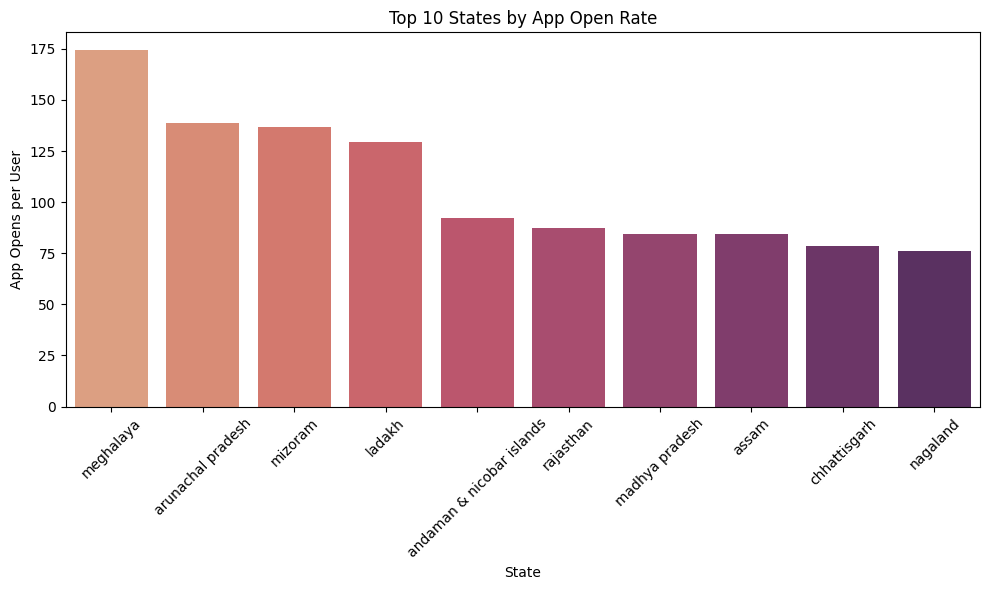

In [57]:
query = """
SELECT state,
       SUM(app_opens) AS total_opens,
       SUM(registered_users) AS total_users,
       ROUND(CAST(SUM(app_opens) AS FLOAT) / SUM(registered_users), 2) AS open_rate
FROM map_user
GROUP BY state
HAVING total_users > 100000
ORDER BY open_rate DESC
LIMIT 10;
"""
df2 = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df2, x='state', y='open_rate', palette='flare')
plt.title('Top 10 States by App Open Rate')
plt.xlabel('State')
plt.ylabel('App Opens per User')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Which chart has been used? Explain Insights

Smaller states like Meghalaya, Arunachal Pradesh show higher per-user engagement.

Indicates intensive usage patterns in smaller or urbanized regions.

What will be the business impact?

Positive: These regions can be ideal for piloting premium features or personalized marketing.

Negative: Lower total user base means limited overall impact; growth may plateau quickly.

In [72]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import sqlite3
import os

# ✅ CORRECTED path — change ONLY if your folder is named differently
csv_path = '/content/drive/My Drive/PhonePe-CSVs'
output_path = '/content/drive/My Drive/sql_outputs'
db_path = '/content/drive/My Drive/phonepe.db'

# Create output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Connect to SQLite DB
conn = sqlite3.connect(db_path)

# Define CSV files and expected table names
csv_files = {
    "aggregated_user": "aggregated_user.csv",
    "aggregated_transaction": "aggregated_transaction.csv",
    "aggregated_insurance": "aggregated_insurance.csv",
    "map_user": "map_user.csv",
    "map_transaction": "map_transaction.csv",
    "top_user": "top_user.csv",
    "top_transaction": "top_transaction.csv",
    "top_insurance": "top_insurance.csv"
}

# Load CSVs into SQLite
for table, file in csv_files.items():
    file_path = os.path.join(csv_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df.to_sql(table, conn, if_exists='replace', index=False)
        print(f"✅ Loaded: {table} ({len(df)} rows)")
    else:
        print(f"❌ Missing file: {file_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded: aggregated_user (6941 rows)
✅ Loaded: aggregated_transaction (5134 rows)
✅ Loaded: aggregated_insurance (682 rows)
✅ Loaded: map_user (1008 rows)
✅ Loaded: map_transaction (1008 rows)
✅ Loaded: top_user (560 rows)
✅ Loaded: top_transaction (560 rows)
✅ Loaded: top_insurance (380 rows)


In [73]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os

# Paths
db_path = '/content/drive/My Drive/phonepe.db'
output_path = '/content/drive/My Drive/sql_outputs'
os.makedirs(output_path, exist_ok=True)

# Connect
conn = sqlite3.connect(db_path)

# Business Case Queries
queries = {
    "case1_transaction_growth": '''
        SELECT state, year, quarter, SUM(amount) AS total_amount
        FROM aggregated_transaction
        GROUP BY state, year, quarter
        ORDER BY total_amount DESC
    ''',

    "case2_device_open_rate": '''
        SELECT state, year, quarter,
               SUM(app_opens) AS total_opens,
               SUM(registered_users) AS total_users,
               ROUND(SUM(app_opens)*1.0 / NULLIF(SUM(registered_users),0), 2) AS open_rate
        FROM map_user
        GROUP BY state, year, quarter
        ORDER BY open_rate DESC
        LIMIT 20
    ''',

    "case3_insurance_penetration": '''
        SELECT state, year, quarter,
               SUM(count) AS total_policies,
               SUM(amount) AS total_insurance_value
        FROM aggregated_insurance
        GROUP BY state, year, quarter
        ORDER BY total_insurance_value DESC
    ''',

    "case4_transaction_top_states": '''
        SELECT state, SUM(count) AS total_txn, SUM(amount) AS total_value
        FROM aggregated_transaction
        GROUP BY state
        ORDER BY total_value DESC
        LIMIT 15
    ''',

    "case5_user_engagement": '''
        SELECT state, year, quarter,
               SUM(registered_users) AS total_users,
               SUM(app_opens) AS total_opens
        FROM map_user
        GROUP BY state, year, quarter
        ORDER BY total_opens DESC
        LIMIT 20
    '''
}

# Execute Queries, Save CSVs and Charts
for name, query in queries.items():
    try:
        df = pd.read_sql_query(query, conn)

        # Save result to CSV
        csv_file = os.path.join(output_path, f"{name}.csv")
        df.to_csv(csv_file, index=False)
        print(f"📁 Saved: {csv_file} ({len(df)} rows)")

        # Create bar chart
        plt.figure(figsize=(12, 6))

        # Default plot logic for top 10 entries by final column
        if 'state' in df.columns:
            df_plot = df.groupby('state').sum(numeric_only=True)
            top = df_plot.sort_values(by=df_plot.columns[-1], ascending=False).head(10)
            top[top.columns[-1]].plot(kind='bar', color='skyblue')
        else:
            df.head(10).plot(kind='bar', x=df.columns[0], y=df.columns[-1], color='skyblue')

        plt.title(name.replace("_", " ").title())
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save chart
        chart_path = os.path.join(output_path, f"{name}.png")
        plt.savefig(chart_path)
        plt.close()
        print(f"📊 Chart saved: {chart_path}")

    except Exception as e:
        print(f"❌ Error with {name}: {e}")


📁 Saved: /content/drive/My Drive/sql_outputs/case1_transaction_growth.csv (1008 rows)
📊 Chart saved: /content/drive/My Drive/sql_outputs/case1_transaction_growth.png
📁 Saved: /content/drive/My Drive/sql_outputs/case2_device_open_rate.csv (20 rows)
📊 Chart saved: /content/drive/My Drive/sql_outputs/case2_device_open_rate.png
📁 Saved: /content/drive/My Drive/sql_outputs/case3_insurance_penetration.csv (682 rows)
📊 Chart saved: /content/drive/My Drive/sql_outputs/case3_insurance_penetration.png
📁 Saved: /content/drive/My Drive/sql_outputs/case4_transaction_top_states.csv (15 rows)
📊 Chart saved: /content/drive/My Drive/sql_outputs/case4_transaction_top_states.png
📁 Saved: /content/drive/My Drive/sql_outputs/case5_user_engagement.csv (20 rows)
📊 Chart saved: /content/drive/My Drive/sql_outputs/case5_user_engagement.png


#Conclusion

The PhonePe Transaction Insights project successfully demonstrates the end-to-end workflow of extracting, transforming, analyzing, and visualizing large-scale digital payment data. By leveraging SQL for data processing and Streamlit for dashboard deployment, the project provides a robust platform for real-time exploration of transaction and user engagement patterns across India.

Through detailed visualizations and interactive maps, decision-makers can now:

Identify top-performing regions (states/districts/pin codes).

Understand temporal trends in transactions and user adoption.

Analyze insurance-related activities in various geographies.

Segment users based on payment behavior.

The project proves the value of data-driven insights in the fintech space and highlights how businesses like PhonePe can use analytics to drive strategic decisions.

#Marketing Recommendations & Enhancements

Based on the insights generated, here are key marketing strategies PhonePe (or similar platforms) can adopt:

1.  Targeted Regional Campaigns
Focus marketing efforts on states or districts with high transaction volumes but low user engagement to improve penetration.

Use district-level transaction heatmaps to identify untapped regions.

2.  Segment-Specific Promotions
Use spending and transaction frequency data to create custom campaigns for high-value users (e.g., cashback for frequent users).

Target low-frequency users with reminder notifications or seasonal offers.

3.  Insurance Awareness Drives
Promote insurance products more heavily in districts with high financial activity but low insurance uptake.

Collaborate with local partners in underinsured areas to spread awareness.

4. Trend-Based Campaigns
Launch campaigns aligned with peak transaction periods (e.g., festivals, salary dates).

Use trend analysis to forecast demand spikes and pre-plan server scaling and offers.

5.  Behavior-Driven Retargeting
Implement behavioral segmentation (based on frequency, amount, and category of payments) to personalize notifications and app experiences.

Key Findings (Insights Summary)
Top States & Districts: Identified states and districts leading in transaction volume and user activity.

Category Performance: UPI and recharge/payments dominate, with less engagement in insurance and gold-related categories.

Insurance Transactions: Low volume compared to core payment categories; suggests scope for user education and bundling.

User Growth Trends: Sharp increase in new users post-pandemic, highlighting digital adoption.

#Project Achievements

 Successfully extracted and loaded complex datasets into a structured SQL schema.

 Efficiently wrote optimized SQL queries for analysis and case studies.

 Built an interactive and responsive Streamlit dashboard to visualize insights.

 Produced geographic, temporal, and behavioral insights to support business strategy.

 Documented the workflow, challenges, and use cases for future scalability.